Text(0, 0.5, 'scaled price($)')

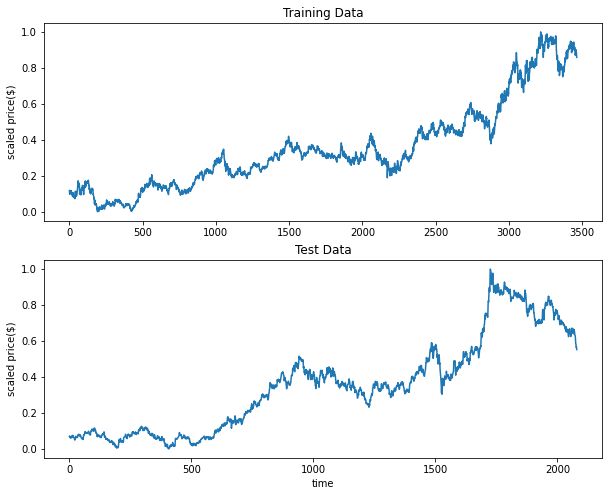

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import FinanceDataReader as fdr


df_train = fdr.DataReader("005930", start = "2000-01-04", end = "2013-12-31")
df_test = fdr.DataReader("005930", start = "2014-01-01", end = "2022-06-17")


training_set = df_train.iloc[:, 3:4].values
test_set = df_test.iloc[:, 3:4].values

sc1 = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc1.fit_transform(training_set)
sc2 = MinMaxScaler(feature_range=(0,1))
test_set_scaled = sc2.fit_transform(test_set)
sc3 = MinMaxScaler(feature_range=(0,1))
sc4 = MinMaxScaler(feature_range=(0,1))

plt.rcParams["figure.figsize"] = (10,8)
plt.subplot(2, 1, 1)
plt.plot(training_set_scaled)
plt.title("Training Data")
plt.ylabel('scaled price($)')

plt.subplot(2, 1, 2)
plt.plot(test_set_scaled)
plt.title("Test Data")
plt.xlabel('time')
plt.ylabel('scaled price($)')

In [48]:
def test(window_size, unit) :
    X_train = []
    Y_train = []
    for i in range(window_size, training_set_scaled.shape[0]):
        X_train.append(training_set_scaled[i-window_size:i, 0])
        Y_train.append(training_set_scaled[i, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    X_test = []
    Y_test = []
    for i in range(window_size, test_set_scaled.shape[0]):
        X_test.append(test_set_scaled[i-window_size:i, 0])
        Y_test.append(test_set_scaled[i, 0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    from keras.models import Sequential
    from keras.layers import Dense, LSTM, Conv1D, Lambda
    from keras.losses import Huber
    from keras.optimizers import Adam
    from keras.callbacks import EarlyStopping, ModelCheckpoint

    model1 = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
            padding="causal",
            activation="relu",
            input_shape=[window_size, 1]),
    # LSTM
    LSTM(unit, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])
    
    # Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
    optimizer = Adam(0.0005)
    model1.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

    # earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
    earlystopping = EarlyStopping(monitor='val_loss', patience=10)
    # val_loss 기준 체크포인터도 생성합니다.
    #filename = os.path.join('tmp', 'ckeckpointer.ckpt')
    # checkpoint = ModelCheckpoint(filename, 
    #                             save_weights_only=True, 
    #                             save_best_only=True, 
    #                             monitor='val_loss', 
    #                             verbose=1)
    history = model1.fit(X_train, Y_train,
                        validation_data=(X_test, Y_test), 
                        epochs=100, 
                        callbacks=[earlystopping])
    
    predicted_X_train1 = model1.predict(X_train)
    predicted_X_train1 = sc1.inverse_transform(predicted_X_train1)

    predicted_X_test1 = model1.predict(X_test)
    predicted_X_test1 = sc2.inverse_transform(predicted_X_test1)

    mean_train_error = np.average(np.abs(training_set[window_size-1:-1,:] - predicted_X_train1))
    mean_test_error = np.average(np.abs(test_set[window_size-1:-1,:] - predicted_X_test1))


    print("Conv added model 평균 training error:", mean_train_error)
    print("Conv added model 평균 test error:",mean_test_error)
    
    graph(predicted_X_train1, predicted_X_test1, window_size)

In [40]:
def test2(window_size, unit) :
    X_train = []
    Y_train = []
    for i in range(window_size, training_set_scaled.shape[0]):
        X_train.append(training_set_scaled[i-window_size:i, 0])
        Y_train.append(training_set_scaled[i, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    X_test = []
    Y_test = []
    for i in range(window_size, test_set_scaled.shape[0]):
        X_test.append(test_set_scaled[i-window_size:i, 0])
        Y_test.append(test_set_scaled[i, 0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    from keras.models import Sequential
    from keras.layers import Dense, LSTM

    model2 = Sequential()
    model2.add(LSTM(unit, input_shape= (window_size, 1), return_sequences=False))
    model2.add(Dense(16, activation="relu"))
    model2.add(Dense(1))
    
    model2.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model2.fit(X_train, Y_train, epochs = 100, batch_size = 32)
    
    predicted_X_train2 = model2.predict(X_train)
    predicted_X_train2 = sc1.inverse_transform(predicted_X_train2)

    predicted_X_test2 = model2.predict(X_test)
    predicted_X_test2 = sc2.inverse_transform(predicted_X_test2)

    mean_train_error = np.average(np.abs(training_set[window_size-1:-1,:] - predicted_X_train2))
    mean_test_error = np.average(np.abs(test_set[window_size-1:-1,:] - predicted_X_test2))

    print("평균 training error:", mean_train_error)
    print("평균 test error:",mean_test_error)
    
    graph(predicted_X_train2, predicted_X_test2, window_size)

In [41]:
def graph(predicted_X_train, predicted_X_test, window_size) :
    plt.subplot(2, 1, 1)
    plt.plot(training_set[window_size:-1,:], color = 'blue', label = 'GroundTruth')
    plt.plot(predicted_X_train, color = 'red', label = 'Prediction')
    plt.title('Samsung Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    plt.subplot(2, 1, 2)
    plt.plot(test_set[window_size:-1,:], color = 'blue', label = 'GroundTruth')
    plt.plot(predicted_X_test, color = 'red', label = 'Prediction')
    plt.title('Samsung Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

window_size : 60
unit :  100
Epoch 1/100
107/107 [==============================] - 3s 13ms/step - loss: 0.0080 - mse: 0.0159 - val_loss: 3.6430e-04 - val_mse: 7.2860e-04
Epoch 2/100
107/107 [==============================] - 1s 10ms/step - loss: 2.2302e-04 - mse: 4.4604e-04 - val_loss: 3.3510e-04 - val_mse: 6.7019e-04
Epoch 3/100
107/107 [==============================] - 1s 10ms/step - loss: 2.0257e-04 - mse: 4.0513e-04 - val_loss: 2.7585e-04 - val_mse: 5.5170e-04
Epoch 4/100
107/107 [==============================] - 1s 10ms/step - loss: 1.8202e-04 - mse: 3.6404e-04 - val_loss: 2.8570e-04 - val_mse: 5.7141e-04
Epoch 5/100
107/107 [==============================] - 1s 10ms/step - loss: 1.6648e-04 - mse: 3.3297e-04 - val_loss: 2.4555e-04 - val_mse: 4.9109e-04
Epoch 6/100
107/107 [==============================] - 1s 10ms/step - loss: 1.5750e-04 - mse: 3.1499e-04 - val_loss: 2.2839e-04 - val_mse: 4.5678e-04
Epoch 7/100
107/107 [==============================] - 1s 10ms/step - loss: 1.4

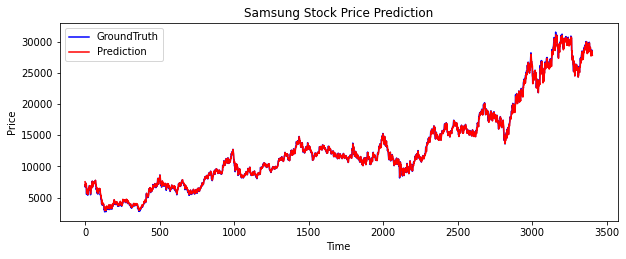

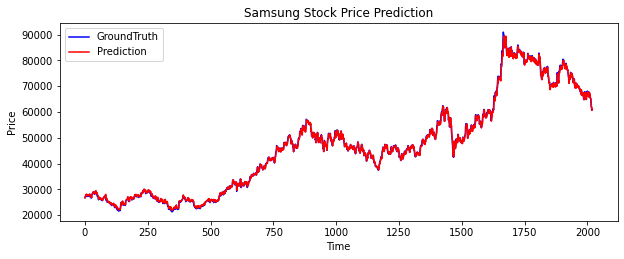

window_size : 60
unit :  75
Epoch 1/100
107/107 [==============================] - 3s 14ms/step - loss: 0.0118 - mse: 0.0237 - val_loss: 4.0645e-04 - val_mse: 8.1290e-04
Epoch 2/100
107/107 [==============================] - 1s 10ms/step - loss: 2.2705e-04 - mse: 4.5411e-04 - val_loss: 3.6603e-04 - val_mse: 7.3206e-04
Epoch 3/100
107/107 [==============================] - 1s 10ms/step - loss: 2.1750e-04 - mse: 4.3500e-04 - val_loss: 3.6225e-04 - val_mse: 7.2451e-04
Epoch 4/100
107/107 [==============================] - 1s 10ms/step - loss: 1.9998e-04 - mse: 3.9997e-04 - val_loss: 2.9513e-04 - val_mse: 5.9026e-04
Epoch 5/100
107/107 [==============================] - 1s 10ms/step - loss: 1.8480e-04 - mse: 3.6959e-04 - val_loss: 2.7301e-04 - val_mse: 5.4602e-04
Epoch 6/100
107/107 [==============================] - 1s 10ms/step - loss: 1.6563e-04 - mse: 3.3127e-04 - val_loss: 2.3674e-04 - val_mse: 4.7348e-04
Epoch 7/100
107/107 [==============================] - 1s 10ms/step - loss: 1.50

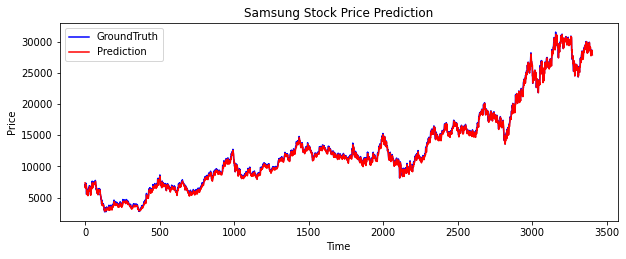

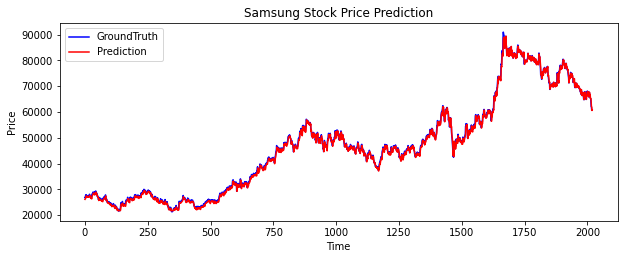

window_size : 60
unit :  50
Epoch 1/100
107/107 [==============================] - 3s 12ms/step - loss: 0.0072 - mse: 0.0144 - val_loss: 2.9861e-04 - val_mse: 5.9722e-04
Epoch 2/100
107/107 [==============================] - 1s 9ms/step - loss: 1.9268e-04 - mse: 3.8535e-04 - val_loss: 2.8406e-04 - val_mse: 5.6811e-04
Epoch 3/100
107/107 [==============================] - 1s 9ms/step - loss: 1.9280e-04 - mse: 3.8559e-04 - val_loss: 3.1616e-04 - val_mse: 6.3231e-04
Epoch 4/100
107/107 [==============================] - 1s 9ms/step - loss: 1.7084e-04 - mse: 3.4167e-04 - val_loss: 2.3914e-04 - val_mse: 4.7828e-04
Epoch 5/100
107/107 [==============================] - 1s 8ms/step - loss: 1.6024e-04 - mse: 3.2047e-04 - val_loss: 2.6024e-04 - val_mse: 5.2049e-04
Epoch 6/100
107/107 [==============================] - 1s 9ms/step - loss: 1.5889e-04 - mse: 3.1778e-04 - val_loss: 2.1164e-04 - val_mse: 4.2328e-04
Epoch 7/100
107/107 [==============================] - 1s 9ms/step - loss: 1.5250e-04

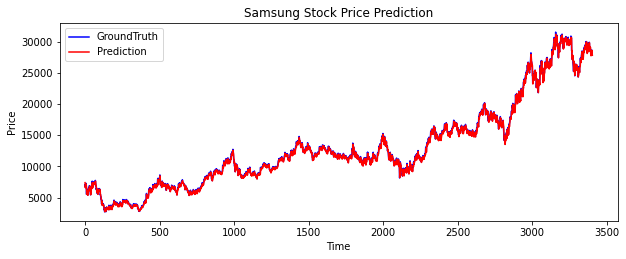

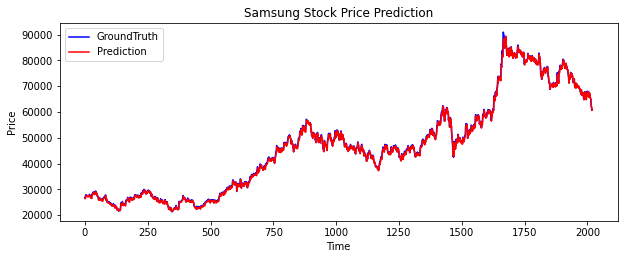

window_size : 60
unit :  25
Epoch 1/100
107/107 [==============================] - 2s 11ms/step - loss: 0.0194 - mse: 0.0388 - val_loss: 4.8281e-04 - val_mse: 9.6562e-04
Epoch 2/100
107/107 [==============================] - 1s 8ms/step - loss: 2.6366e-04 - mse: 5.2732e-04 - val_loss: 4.0258e-04 - val_mse: 8.0516e-04
Epoch 3/100
107/107 [==============================] - 1s 8ms/step - loss: 2.4024e-04 - mse: 4.8047e-04 - val_loss: 3.8857e-04 - val_mse: 7.7714e-04
Epoch 4/100
107/107 [==============================] - 1s 8ms/step - loss: 2.1972e-04 - mse: 4.3944e-04 - val_loss: 3.5801e-04 - val_mse: 7.1602e-04
Epoch 5/100
107/107 [==============================] - 1s 8ms/step - loss: 2.0917e-04 - mse: 4.1833e-04 - val_loss: 3.3493e-04 - val_mse: 6.6986e-04
Epoch 6/100
107/107 [==============================] - 1s 8ms/step - loss: 2.0363e-04 - mse: 4.0727e-04 - val_loss: 3.2508e-04 - val_mse: 6.5016e-04
Epoch 7/100
107/107 [==============================] - 1s 8ms/step - loss: 2.0306e-04

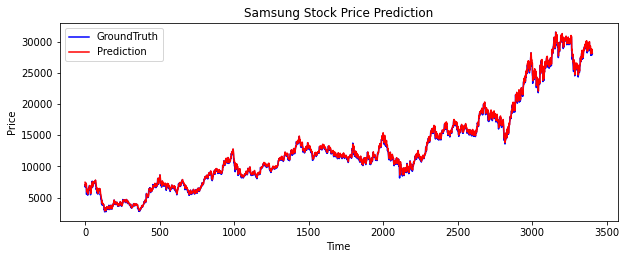

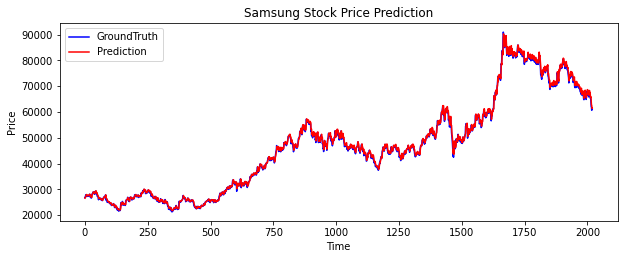

window_size : 30
unit :  100
Epoch 1/100
108/108 [==============================] - 2s 10ms/step - loss: 0.0129 - mse: 0.0259 - val_loss: 4.9210e-04 - val_mse: 9.8421e-04
Epoch 2/100
108/108 [==============================] - 1s 7ms/step - loss: 2.6241e-04 - mse: 5.2482e-04 - val_loss: 4.2886e-04 - val_mse: 8.5771e-04
Epoch 3/100
108/108 [==============================] - 1s 7ms/step - loss: 2.6212e-04 - mse: 5.2423e-04 - val_loss: 3.9501e-04 - val_mse: 7.9002e-04
Epoch 4/100
108/108 [==============================] - 1s 7ms/step - loss: 2.4583e-04 - mse: 4.9165e-04 - val_loss: 3.8355e-04 - val_mse: 7.6709e-04
Epoch 5/100
108/108 [==============================] - 1s 7ms/step - loss: 2.5396e-04 - mse: 5.0793e-04 - val_loss: 3.5257e-04 - val_mse: 7.0514e-04
Epoch 6/100
108/108 [==============================] - 1s 7ms/step - loss: 2.3485e-04 - mse: 4.6970e-04 - val_loss: 3.9692e-04 - val_mse: 7.9383e-04
Epoch 7/100
108/108 [==============================] - 1s 7ms/step - loss: 2.2516e-0

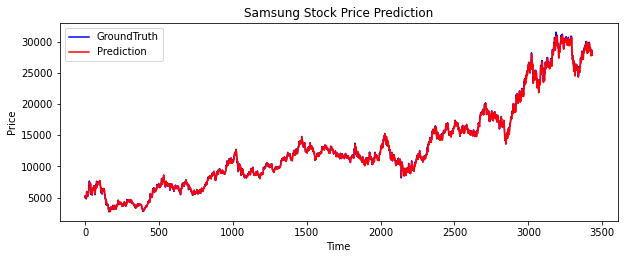

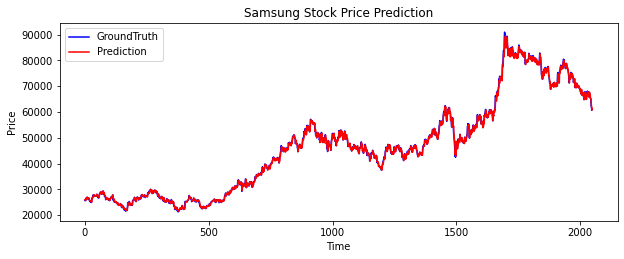

window_size : 30
unit :  75
Epoch 1/100
108/108 [==============================] - 3s 10ms/step - loss: 0.0094 - mse: 0.0189 - val_loss: 3.9251e-04 - val_mse: 7.8502e-04
Epoch 2/100
108/108 [==============================] - 1s 7ms/step - loss: 2.3642e-04 - mse: 4.7284e-04 - val_loss: 3.9679e-04 - val_mse: 7.9358e-04
Epoch 3/100
108/108 [==============================] - 1s 6ms/step - loss: 2.2013e-04 - mse: 4.4025e-04 - val_loss: 3.3585e-04 - val_mse: 6.7170e-04
Epoch 4/100
108/108 [==============================] - 1s 7ms/step - loss: 2.0127e-04 - mse: 4.0255e-04 - val_loss: 2.9745e-04 - val_mse: 5.9490e-04
Epoch 5/100
108/108 [==============================] - 1s 7ms/step - loss: 1.8556e-04 - mse: 3.7112e-04 - val_loss: 2.8643e-04 - val_mse: 5.7286e-04
Epoch 6/100
108/108 [==============================] - 1s 7ms/step - loss: 1.6936e-04 - mse: 3.3873e-04 - val_loss: 2.4511e-04 - val_mse: 4.9023e-04
Epoch 7/100
108/108 [==============================] - 1s 7ms/step - loss: 1.5732e-04

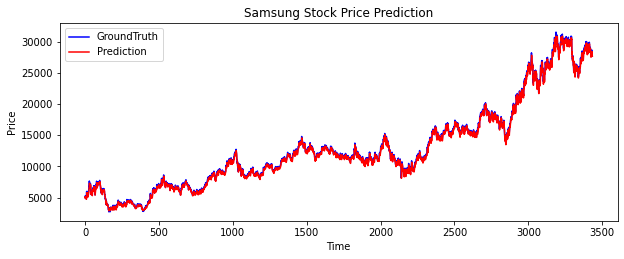

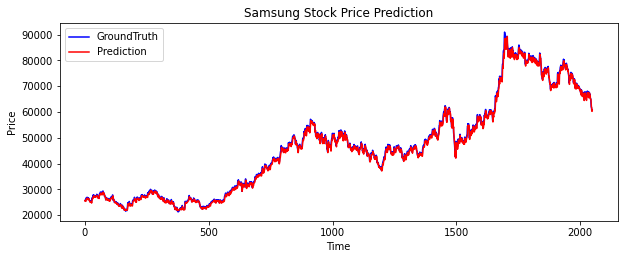

window_size : 30
unit :  50
Epoch 1/100
108/108 [==============================] - 2s 9ms/step - loss: 0.0121 - mse: 0.0242 - val_loss: 4.3597e-04 - val_mse: 8.7194e-04
Epoch 2/100
108/108 [==============================] - 1s 6ms/step - loss: 2.6853e-04 - mse: 5.3706e-04 - val_loss: 4.2270e-04 - val_mse: 8.4540e-04
Epoch 3/100
108/108 [==============================] - 1s 6ms/step - loss: 2.5904e-04 - mse: 5.1808e-04 - val_loss: 4.0327e-04 - val_mse: 8.0655e-04
Epoch 4/100
108/108 [==============================] - 1s 6ms/step - loss: 2.5928e-04 - mse: 5.1855e-04 - val_loss: 3.8853e-04 - val_mse: 7.7706e-04
Epoch 5/100
108/108 [==============================] - 1s 6ms/step - loss: 2.3799e-04 - mse: 4.7598e-04 - val_loss: 3.7835e-04 - val_mse: 7.5671e-04
Epoch 6/100
108/108 [==============================] - 1s 6ms/step - loss: 2.3442e-04 - mse: 4.6884e-04 - val_loss: 3.5092e-04 - val_mse: 7.0184e-04
Epoch 7/100
108/108 [==============================] - 1s 6ms/step - loss: 2.2337e-04 

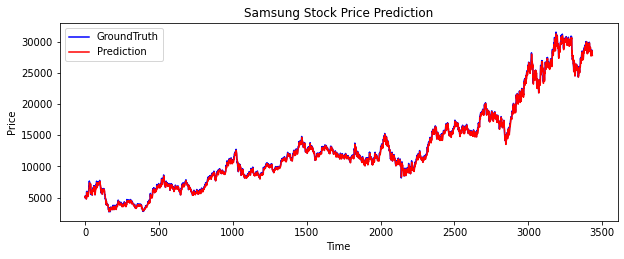

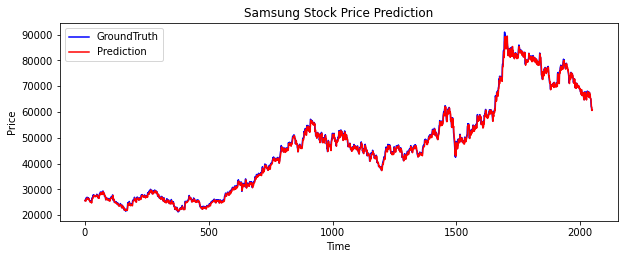

window_size : 30
unit :  25
Epoch 1/100
108/108 [==============================] - 2s 10ms/step - loss: 0.0087 - mse: 0.0174 - val_loss: 4.2345e-04 - val_mse: 8.4689e-04
Epoch 2/100
108/108 [==============================] - 1s 6ms/step - loss: 2.5312e-04 - mse: 5.0624e-04 - val_loss: 4.0535e-04 - val_mse: 8.1070e-04
Epoch 3/100
108/108 [==============================] - 1s 6ms/step - loss: 2.4596e-04 - mse: 4.9191e-04 - val_loss: 4.0625e-04 - val_mse: 8.1250e-04
Epoch 4/100
108/108 [==============================] - 1s 7ms/step - loss: 2.3685e-04 - mse: 4.7369e-04 - val_loss: 4.4300e-04 - val_mse: 8.8601e-04
Epoch 5/100
108/108 [==============================] - 1s 7ms/step - loss: 2.3582e-04 - mse: 4.7163e-04 - val_loss: 3.7238e-04 - val_mse: 7.4477e-04
Epoch 6/100
108/108 [==============================] - 1s 6ms/step - loss: 2.1965e-04 - mse: 4.3930e-04 - val_loss: 3.4533e-04 - val_mse: 6.9066e-04
Epoch 7/100
108/108 [==============================] - 1s 6ms/step - loss: 2.1583e-04

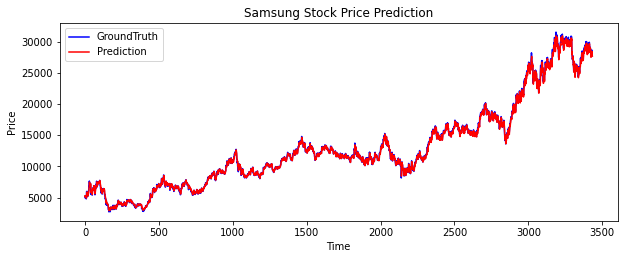

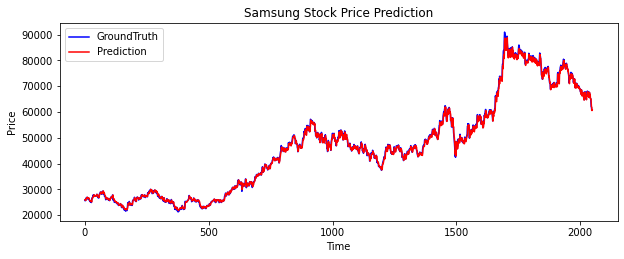

window_size : 20
unit :  100
Epoch 1/100
108/108 [==============================] - 2s 9ms/step - loss: 0.0037 - mse: 0.0074 - val_loss: 3.5599e-04 - val_mse: 7.1197e-04
Epoch 2/100
108/108 [==============================] - 1s 6ms/step - loss: 2.1036e-04 - mse: 4.2072e-04 - val_loss: 3.0970e-04 - val_mse: 6.1939e-04
Epoch 3/100
108/108 [==============================] - 1s 6ms/step - loss: 1.9551e-04 - mse: 3.9103e-04 - val_loss: 2.9001e-04 - val_mse: 5.8003e-04
Epoch 4/100
108/108 [==============================] - 1s 6ms/step - loss: 1.8240e-04 - mse: 3.6480e-04 - val_loss: 2.5467e-04 - val_mse: 5.0935e-04
Epoch 5/100
108/108 [==============================] - 1s 6ms/step - loss: 1.6901e-04 - mse: 3.3801e-04 - val_loss: 2.3310e-04 - val_mse: 4.6619e-04
Epoch 6/100
108/108 [==============================] - 1s 6ms/step - loss: 1.6139e-04 - mse: 3.2279e-04 - val_loss: 2.2579e-04 - val_mse: 4.5158e-04
Epoch 7/100
108/108 [==============================] - 1s 6ms/step - loss: 1.4257e-04

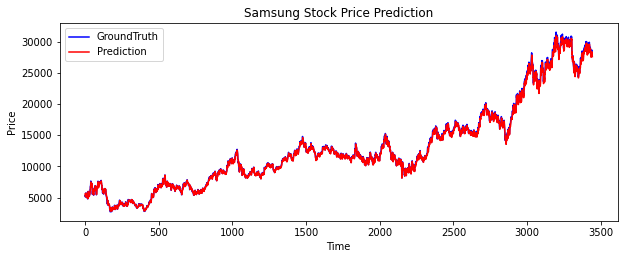

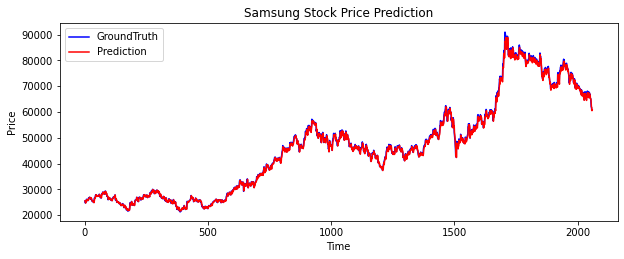

window_size : 20
unit :  75
Epoch 1/100
108/108 [==============================] - 3s 10ms/step - loss: 0.0091 - mse: 0.0182 - val_loss: 4.0630e-04 - val_mse: 8.1259e-04
Epoch 2/100
108/108 [==============================] - 1s 7ms/step - loss: 2.4214e-04 - mse: 4.8429e-04 - val_loss: 3.9770e-04 - val_mse: 7.9541e-04
Epoch 3/100
108/108 [==============================] - 1s 7ms/step - loss: 2.3603e-04 - mse: 4.7206e-04 - val_loss: 3.4966e-04 - val_mse: 6.9933e-04
Epoch 4/100
108/108 [==============================] - 1s 7ms/step - loss: 2.1956e-04 - mse: 4.3913e-04 - val_loss: 3.6288e-04 - val_mse: 7.2575e-04
Epoch 5/100
108/108 [==============================] - 1s 8ms/step - loss: 2.1920e-04 - mse: 4.3840e-04 - val_loss: 3.3297e-04 - val_mse: 6.6593e-04
Epoch 6/100
108/108 [==============================] - 1s 6ms/step - loss: 2.0741e-04 - mse: 4.1483e-04 - val_loss: 3.3482e-04 - val_mse: 6.6964e-04
Epoch 7/100
108/108 [==============================] - 1s 6ms/step - loss: 2.0189e-04

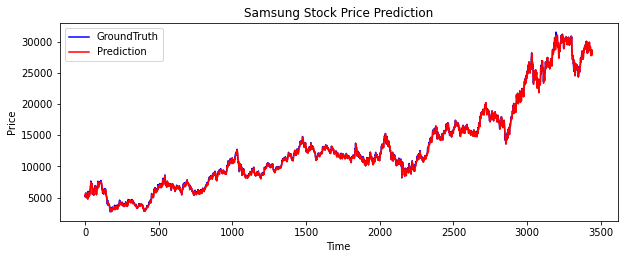

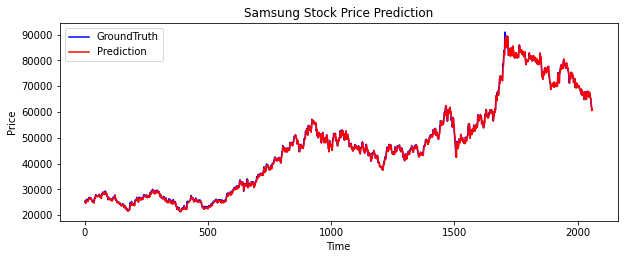

window_size : 20
unit :  50
Epoch 1/100
108/108 [==============================] - 2s 10ms/step - loss: 0.0099 - mse: 0.0199 - val_loss: 3.4348e-04 - val_mse: 6.8696e-04
Epoch 2/100
108/108 [==============================] - 1s 7ms/step - loss: 2.0471e-04 - mse: 4.0943e-04 - val_loss: 3.0868e-04 - val_mse: 6.1736e-04
Epoch 3/100
108/108 [==============================] - 1s 7ms/step - loss: 1.9659e-04 - mse: 3.9319e-04 - val_loss: 2.9936e-04 - val_mse: 5.9873e-04
Epoch 4/100
108/108 [==============================] - 1s 6ms/step - loss: 1.8514e-04 - mse: 3.7027e-04 - val_loss: 2.8055e-04 - val_mse: 5.6110e-04
Epoch 5/100
108/108 [==============================] - 1s 8ms/step - loss: 1.8182e-04 - mse: 3.6364e-04 - val_loss: 2.5961e-04 - val_mse: 5.1922e-04
Epoch 6/100
108/108 [==============================] - 1s 7ms/step - loss: 1.7298e-04 - mse: 3.4595e-04 - val_loss: 2.4306e-04 - val_mse: 4.8612e-04
Epoch 7/100
108/108 [==============================] - 1s 6ms/step - loss: 1.6440e-04

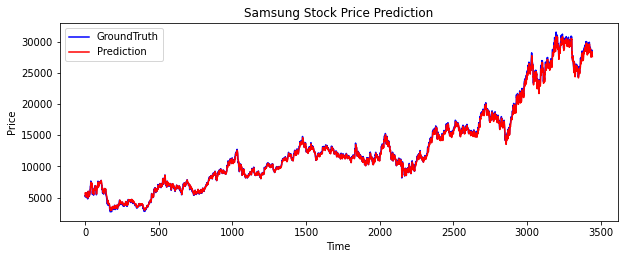

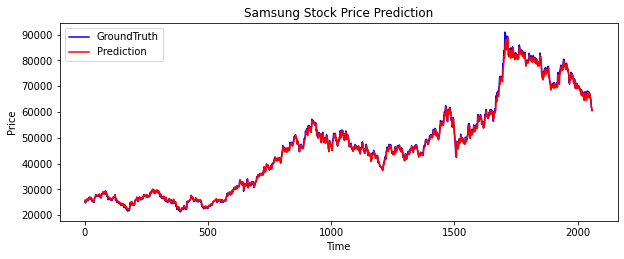

window_size : 20
unit :  25
Epoch 1/100
108/108 [==============================] - 2s 9ms/step - loss: 0.0161 - mse: 0.0322 - val_loss: 3.5209e-04 - val_mse: 7.0418e-04
Epoch 2/100
108/108 [==============================] - 1s 6ms/step - loss: 1.9101e-04 - mse: 3.8201e-04 - val_loss: 3.1242e-04 - val_mse: 6.2485e-04
Epoch 3/100
108/108 [==============================] - 1s 6ms/step - loss: 1.8558e-04 - mse: 3.7117e-04 - val_loss: 2.8526e-04 - val_mse: 5.7052e-04
Epoch 4/100
108/108 [==============================] - 1s 6ms/step - loss: 1.8201e-04 - mse: 3.6401e-04 - val_loss: 2.8136e-04 - val_mse: 5.6273e-04
Epoch 5/100
108/108 [==============================] - 1s 6ms/step - loss: 1.7837e-04 - mse: 3.5675e-04 - val_loss: 2.7721e-04 - val_mse: 5.5442e-04
Epoch 6/100
108/108 [==============================] - 1s 6ms/step - loss: 1.7497e-04 - mse: 3.4995e-04 - val_loss: 2.6365e-04 - val_mse: 5.2729e-04
Epoch 7/100
108/108 [==============================] - 1s 6ms/step - loss: 1.7171e-04 

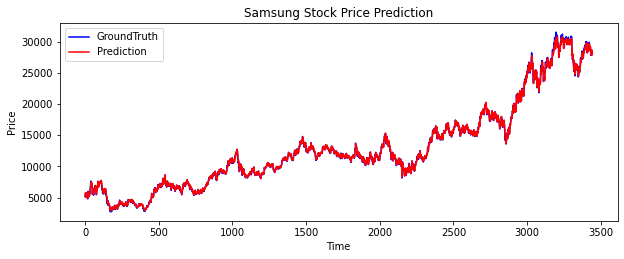

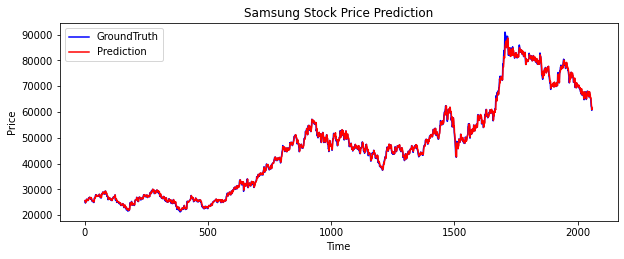

window_size : 10
unit :  100
Epoch 1/100
108/108 [==============================] - 2s 8ms/step - loss: 0.0099 - mse: 0.0198 - val_loss: 3.3565e-04 - val_mse: 6.7130e-04
Epoch 2/100
108/108 [==============================] - 1s 5ms/step - loss: 1.9841e-04 - mse: 3.9682e-04 - val_loss: 2.8401e-04 - val_mse: 5.6802e-04
Epoch 3/100
108/108 [==============================] - 1s 5ms/step - loss: 1.8249e-04 - mse: 3.6497e-04 - val_loss: 2.5605e-04 - val_mse: 5.1211e-04
Epoch 4/100
108/108 [==============================] - 1s 5ms/step - loss: 1.7654e-04 - mse: 3.5307e-04 - val_loss: 2.5050e-04 - val_mse: 5.0100e-04
Epoch 5/100
108/108 [==============================] - 1s 5ms/step - loss: 1.6430e-04 - mse: 3.2860e-04 - val_loss: 2.3052e-04 - val_mse: 4.6103e-04
Epoch 6/100
108/108 [==============================] - 1s 5ms/step - loss: 1.6075e-04 - mse: 3.2151e-04 - val_loss: 2.1005e-04 - val_mse: 4.2010e-04
Epoch 7/100
108/108 [==============================] - 1s 5ms/step - loss: 1.4551e-04

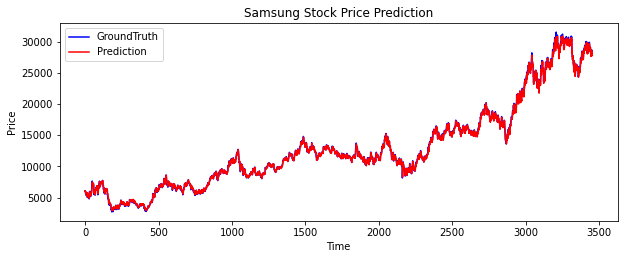

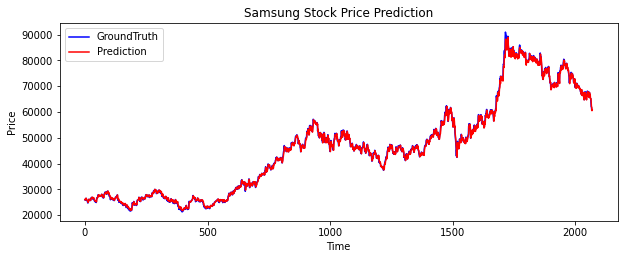

window_size : 10
unit :  75
Epoch 1/100
108/108 [==============================] - 2s 9ms/step - loss: 0.0127 - mse: 0.0253 - val_loss: 3.2887e-04 - val_mse: 6.5774e-04
Epoch 2/100
108/108 [==============================] - 1s 5ms/step - loss: 2.0530e-04 - mse: 4.1060e-04 - val_loss: 2.8497e-04 - val_mse: 5.6993e-04
Epoch 3/100
108/108 [==============================] - 1s 5ms/step - loss: 1.8984e-04 - mse: 3.7967e-04 - val_loss: 2.8785e-04 - val_mse: 5.7570e-04
Epoch 4/100
108/108 [==============================] - 1s 5ms/step - loss: 1.8570e-04 - mse: 3.7139e-04 - val_loss: 2.6546e-04 - val_mse: 5.3091e-04
Epoch 5/100
108/108 [==============================] - 1s 5ms/step - loss: 1.7576e-04 - mse: 3.5151e-04 - val_loss: 2.5947e-04 - val_mse: 5.1894e-04
Epoch 6/100
108/108 [==============================] - 1s 5ms/step - loss: 1.8254e-04 - mse: 3.6507e-04 - val_loss: 2.4957e-04 - val_mse: 4.9914e-04
Epoch 7/100
108/108 [==============================] - 1s 6ms/step - loss: 1.7816e-04 

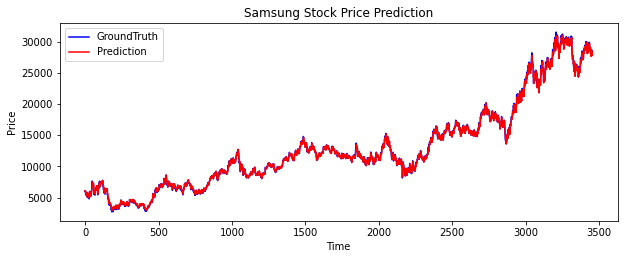

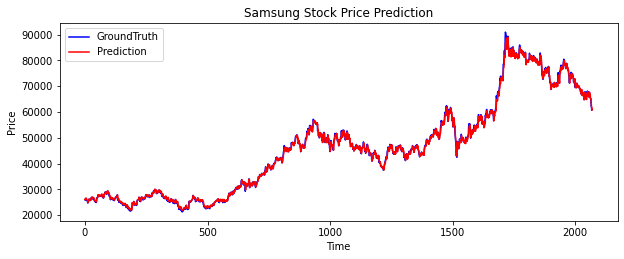

window_size : 10
unit :  50
Epoch 1/100
108/108 [==============================] - 2s 8ms/step - loss: 0.0160 - mse: 0.0321 - val_loss: 2.9741e-04 - val_mse: 5.9482e-04
Epoch 2/100
108/108 [==============================] - 1s 6ms/step - loss: 1.7878e-04 - mse: 3.5757e-04 - val_loss: 2.5856e-04 - val_mse: 5.1711e-04
Epoch 3/100
108/108 [==============================] - 1s 5ms/step - loss: 1.7254e-04 - mse: 3.4508e-04 - val_loss: 2.4987e-04 - val_mse: 4.9974e-04
Epoch 4/100
108/108 [==============================] - 1s 5ms/step - loss: 1.6955e-04 - mse: 3.3911e-04 - val_loss: 2.5844e-04 - val_mse: 5.1689e-04
Epoch 5/100
108/108 [==============================] - 1s 5ms/step - loss: 1.6532e-04 - mse: 3.3065e-04 - val_loss: 2.3592e-04 - val_mse: 4.7184e-04
Epoch 6/100
108/108 [==============================] - 1s 5ms/step - loss: 1.5746e-04 - mse: 3.1492e-04 - val_loss: 2.3041e-04 - val_mse: 4.6082e-04
Epoch 7/100
108/108 [==============================] - 1s 5ms/step - loss: 1.5538e-04 

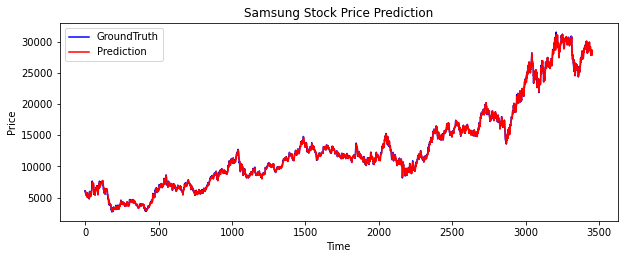

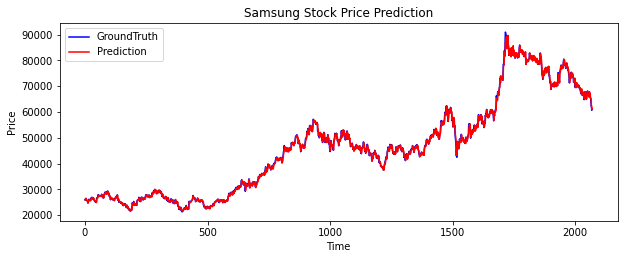

window_size : 10
unit :  25
Epoch 1/100
108/108 [==============================] - 2s 8ms/step - loss: 0.0205 - mse: 0.0411 - val_loss: 3.1740e-04 - val_mse: 6.3481e-04
Epoch 2/100
108/108 [==============================] - 1s 5ms/step - loss: 1.8297e-04 - mse: 3.6593e-04 - val_loss: 2.5650e-04 - val_mse: 5.1301e-04
Epoch 3/100
108/108 [==============================] - 1s 5ms/step - loss: 1.7297e-04 - mse: 3.4594e-04 - val_loss: 2.5588e-04 - val_mse: 5.1177e-04
Epoch 4/100
108/108 [==============================] - 1s 5ms/step - loss: 1.6449e-04 - mse: 3.2898e-04 - val_loss: 2.4615e-04 - val_mse: 4.9230e-04
Epoch 5/100
108/108 [==============================] - 1s 5ms/step - loss: 1.5849e-04 - mse: 3.1697e-04 - val_loss: 2.3108e-04 - val_mse: 4.6217e-04
Epoch 6/100
108/108 [==============================] - 1s 5ms/step - loss: 1.6094e-04 - mse: 3.2189e-04 - val_loss: 2.2029e-04 - val_mse: 4.4058e-04
Epoch 7/100
108/108 [==============================] - 1s 5ms/step - loss: 1.5129e-04 

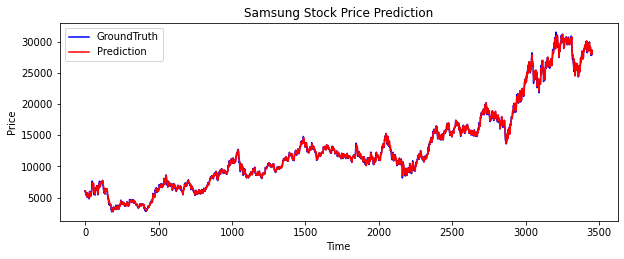

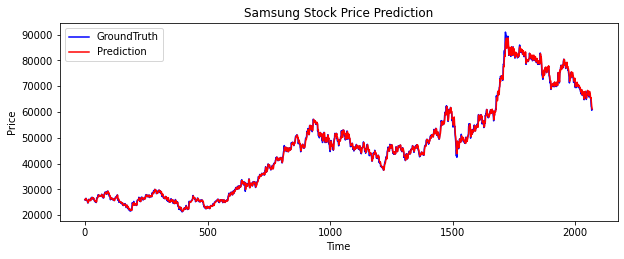

In [49]:
windows = [60, 30, 20, 10]
units = [100, 75, 50, 25]

for window in windows :
    for unit in units :
        print("window_size :" , window)
        print("unit : ", unit)
        test(window, unit)

window_size : 60
unit :  100
Epoch 1/100
107/107 [==============================] - 2s 6ms/step - loss: 0.0104
Epoch 2/100
107/107 [==============================] - 1s 6ms/step - loss: 3.5757e-04
Epoch 3/100
107/107 [==============================] - 1s 6ms/step - loss: 3.6089e-04
Epoch 4/100
107/107 [==============================] - 1s 6ms/step - loss: 3.2682e-04
Epoch 5/100
107/107 [==============================] - 1s 6ms/step - loss: 3.2723e-04
Epoch 6/100
107/107 [==============================] - 1s 6ms/step - loss: 3.1992e-04
Epoch 7/100
107/107 [==============================] - 1s 6ms/step - loss: 2.7035e-04
Epoch 8/100
107/107 [==============================] - 1s 6ms/step - loss: 2.4869e-04
Epoch 9/100
107/107 [==============================] - 1s 6ms/step - loss: 2.6492e-04
Epoch 10/100
107/107 [==============================] - 1s 6ms/step - loss: 2.4090e-04
Epoch 11/100
107/107 [==============================] - 1s 6ms/step - loss: 2.3819e-04
Epoch 12/100
107/107 [=====

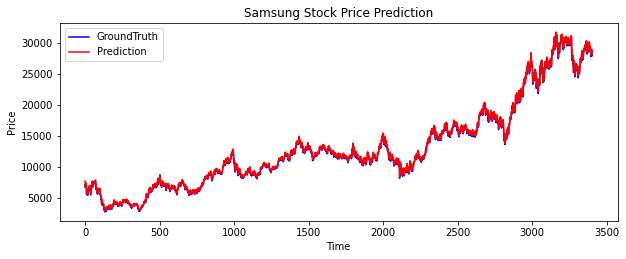

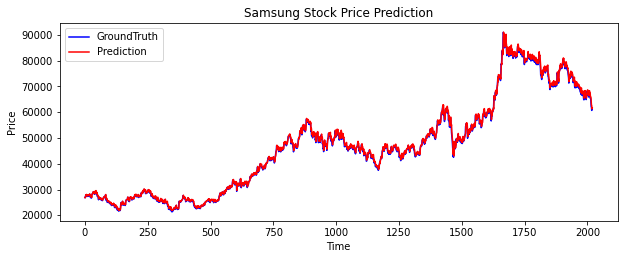

window_size : 60
unit :  75
Epoch 1/100
107/107 [==============================] - 2s 7ms/step - loss: 0.0125
Epoch 2/100
107/107 [==============================] - 1s 6ms/step - loss: 4.6856e-04
Epoch 3/100
107/107 [==============================] - 1s 6ms/step - loss: 3.9897e-04
Epoch 4/100
107/107 [==============================] - 1s 6ms/step - loss: 4.0408e-04
Epoch 5/100
107/107 [==============================] - 1s 6ms/step - loss: 3.8122e-04
Epoch 6/100
107/107 [==============================] - 1s 6ms/step - loss: 3.7576e-04
Epoch 7/100
107/107 [==============================] - 1s 6ms/step - loss: 3.2627e-04
Epoch 8/100
107/107 [==============================] - 1s 6ms/step - loss: 3.2360e-04
Epoch 9/100
107/107 [==============================] - 1s 6ms/step - loss: 3.1413e-04
Epoch 10/100
107/107 [==============================] - 1s 7ms/step - loss: 3.4003e-04
Epoch 11/100
107/107 [==============================] - 1s 8ms/step - loss: 2.9062e-04
Epoch 12/100
107/107 [======

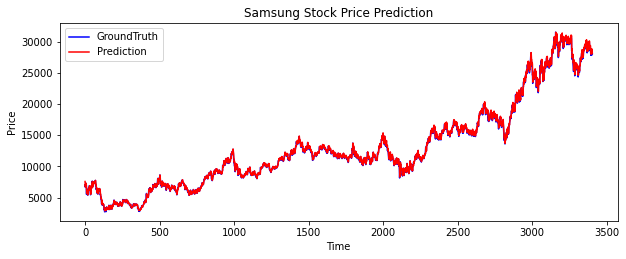

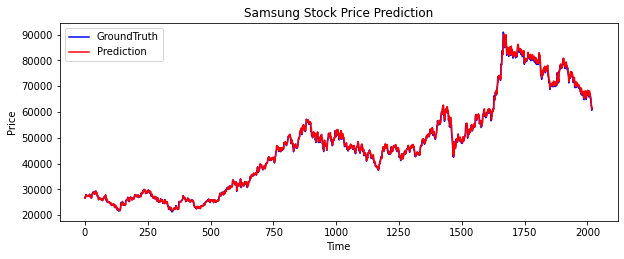

window_size : 60
unit :  50
Epoch 1/100
107/107 [==============================] - 2s 6ms/step - loss: 0.0126
Epoch 2/100
107/107 [==============================] - 1s 6ms/step - loss: 3.2545e-04
Epoch 3/100
107/107 [==============================] - 1s 6ms/step - loss: 3.0202e-04
Epoch 4/100
107/107 [==============================] - 1s 7ms/step - loss: 3.0727e-04
Epoch 5/100
107/107 [==============================] - 1s 7ms/step - loss: 2.7728e-04
Epoch 6/100
107/107 [==============================] - 1s 6ms/step - loss: 2.8243e-04
Epoch 7/100
107/107 [==============================] - 1s 6ms/step - loss: 2.4969e-04
Epoch 8/100
107/107 [==============================] - 1s 6ms/step - loss: 2.3145e-04
Epoch 9/100
107/107 [==============================] - 1s 6ms/step - loss: 2.2466e-04
Epoch 10/100
107/107 [==============================] - 1s 6ms/step - loss: 2.5133e-04
Epoch 11/100
107/107 [==============================] - 1s 6ms/step - loss: 2.3012e-04
Epoch 12/100
107/107 [======

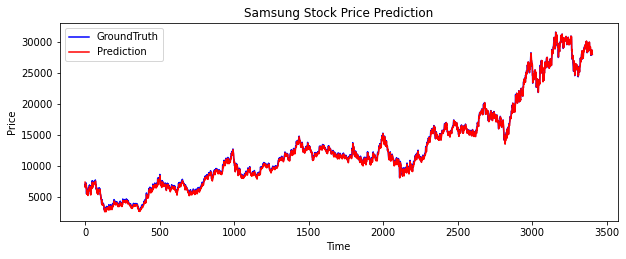

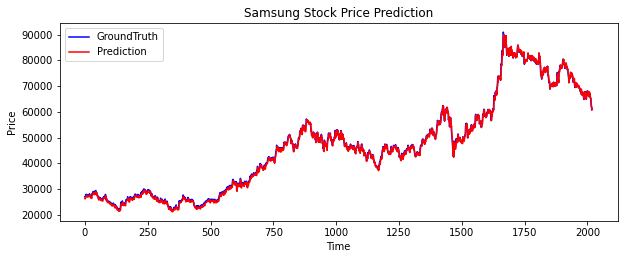

window_size : 60
unit :  25
Epoch 1/100
107/107 [==============================] - 2s 5ms/step - loss: 0.0076
Epoch 2/100
107/107 [==============================] - 1s 5ms/step - loss: 2.8328e-04
Epoch 3/100
107/107 [==============================] - 1s 5ms/step - loss: 2.7526e-04
Epoch 4/100
107/107 [==============================] - 1s 5ms/step - loss: 2.7217e-04
Epoch 5/100
107/107 [==============================] - 1s 5ms/step - loss: 2.7236e-04
Epoch 6/100
107/107 [==============================] - 1s 5ms/step - loss: 2.5141e-04
Epoch 7/100
107/107 [==============================] - 1s 5ms/step - loss: 2.4485e-04
Epoch 8/100
107/107 [==============================] - 1s 5ms/step - loss: 2.4363e-04
Epoch 9/100
107/107 [==============================] - 1s 5ms/step - loss: 2.2632e-04
Epoch 10/100
107/107 [==============================] - 1s 5ms/step - loss: 2.2636e-04
Epoch 11/100
107/107 [==============================] - 1s 5ms/step - loss: 2.0853e-04
Epoch 12/100
107/107 [======

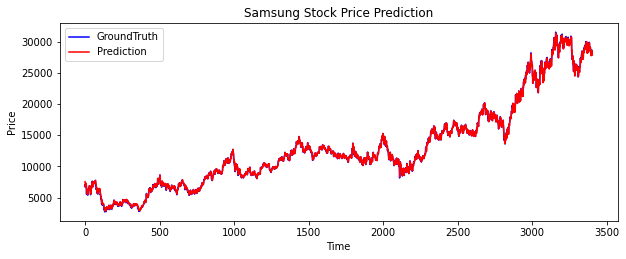

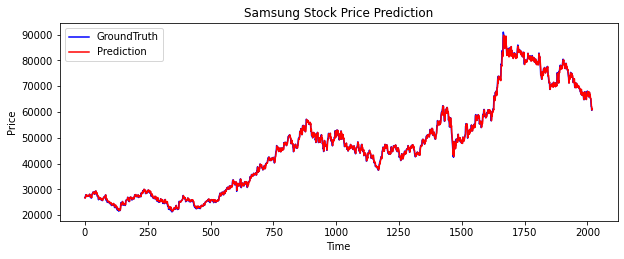

window_size : 30
unit :  100
Epoch 1/100
108/108 [==============================] - 2s 5ms/step - loss: 0.0063
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 3.3238e-04
Epoch 3/100
108/108 [==============================] - 0s 4ms/step - loss: 2.9829e-04
Epoch 4/100
108/108 [==============================] - 0s 4ms/step - loss: 3.0464e-04
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss: 2.6709e-04
Epoch 6/100
108/108 [==============================] - 0s 4ms/step - loss: 2.5800e-04
Epoch 7/100
108/108 [==============================] - 0s 5ms/step - loss: 2.4262e-04
Epoch 8/100
108/108 [==============================] - 0s 4ms/step - loss: 2.1046e-04
Epoch 9/100
108/108 [==============================] - 0s 4ms/step - loss: 2.0270e-04
Epoch 10/100
108/108 [==============================] - 0s 4ms/step - loss: 1.9894e-04
Epoch 11/100
108/108 [==============================] - 0s 4ms/step - loss: 2.1524e-04
Epoch 12/100
108/108 [=====

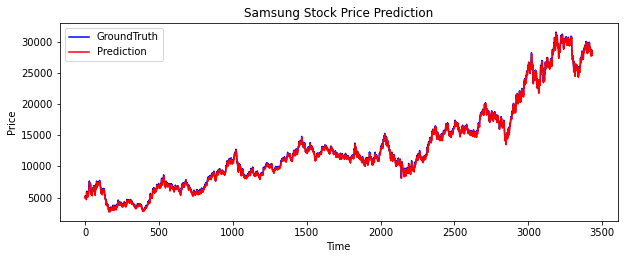

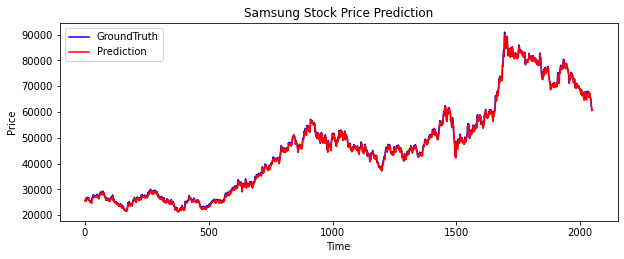

window_size : 30
unit :  75
Epoch 1/100
108/108 [==============================] - 2s 4ms/step - loss: 0.0079
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 3.1170e-04
Epoch 3/100
108/108 [==============================] - 0s 4ms/step - loss: 2.8594e-04
Epoch 4/100
108/108 [==============================] - 0s 4ms/step - loss: 2.6832e-04
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss: 2.4321e-04
Epoch 6/100
108/108 [==============================] - 0s 4ms/step - loss: 2.3120e-04
Epoch 7/100
108/108 [==============================] - 0s 4ms/step - loss: 2.4332e-04
Epoch 8/100
108/108 [==============================] - 0s 4ms/step - loss: 2.4081e-04
Epoch 9/100
108/108 [==============================] - 0s 4ms/step - loss: 2.2067e-04
Epoch 10/100
108/108 [==============================] - 0s 4ms/step - loss: 2.1268e-04
Epoch 11/100
108/108 [==============================] - 0s 4ms/step - loss: 2.1111e-04
Epoch 12/100
108/108 [======

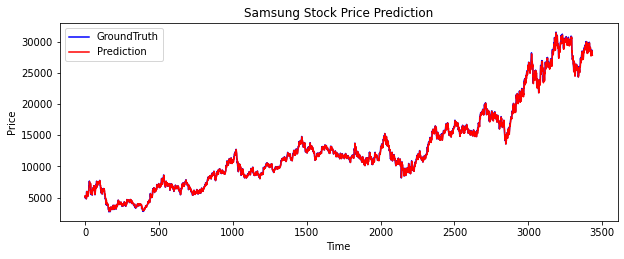

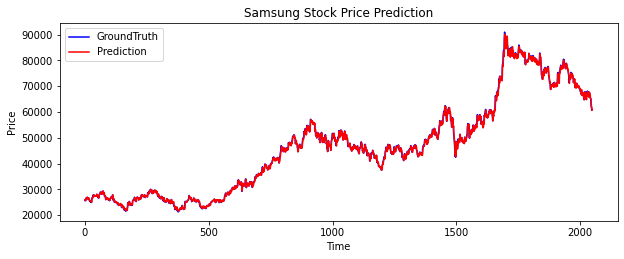

window_size : 30
unit :  50
Epoch 1/100
108/108 [==============================] - 2s 4ms/step - loss: 0.0067
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 3.4120e-04
Epoch 3/100
108/108 [==============================] - 0s 4ms/step - loss: 3.2536e-04
Epoch 4/100
108/108 [==============================] - 0s 4ms/step - loss: 3.2050e-04
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss: 2.9117e-04
Epoch 6/100
108/108 [==============================] - 0s 4ms/step - loss: 2.7480e-04
Epoch 7/100
108/108 [==============================] - 0s 4ms/step - loss: 2.8328e-04
Epoch 8/100
108/108 [==============================] - 0s 4ms/step - loss: 2.4447e-04
Epoch 9/100
108/108 [==============================] - 0s 4ms/step - loss: 2.1711e-04
Epoch 10/100
108/108 [==============================] - 0s 4ms/step - loss: 2.2690e-04
Epoch 11/100
108/108 [==============================] - 0s 4ms/step - loss: 2.1314e-04
Epoch 12/100
108/108 [======

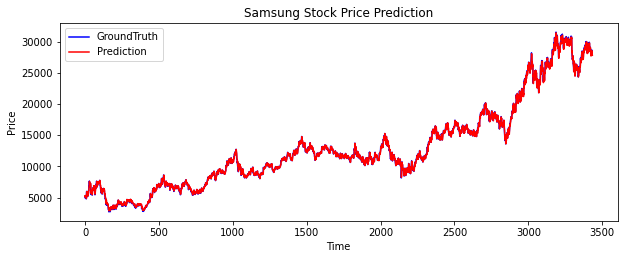

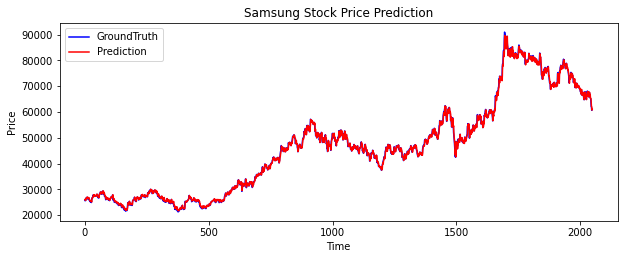

window_size : 30
unit :  25
Epoch 1/100
108/108 [==============================] - 2s 5ms/step - loss: 0.0145
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 2.9783e-04
Epoch 3/100
108/108 [==============================] - 0s 4ms/step - loss: 2.9848e-04
Epoch 4/100
108/108 [==============================] - 0s 4ms/step - loss: 2.8424e-04
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss: 2.7321e-04
Epoch 6/100
108/108 [==============================] - 0s 4ms/step - loss: 2.5864e-04
Epoch 7/100
108/108 [==============================] - 0s 4ms/step - loss: 2.5965e-04
Epoch 8/100
108/108 [==============================] - 0s 4ms/step - loss: 2.4640e-04
Epoch 9/100
108/108 [==============================] - 0s 4ms/step - loss: 2.4142e-04
Epoch 10/100
108/108 [==============================] - 0s 4ms/step - loss: 2.3098e-04
Epoch 11/100
108/108 [==============================] - 0s 4ms/step - loss: 2.2038e-04
Epoch 12/100
108/108 [======

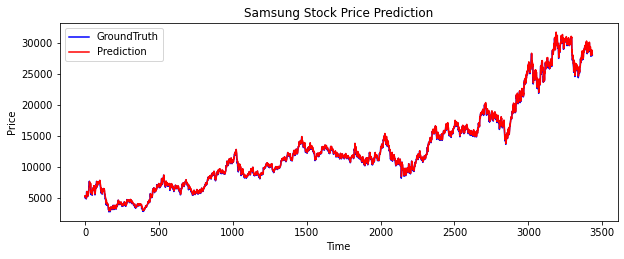

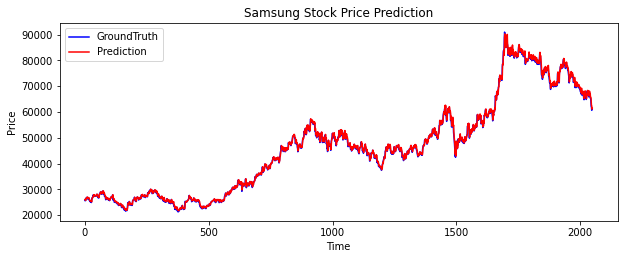

window_size : 20
unit :  100
Epoch 1/100
108/108 [==============================] - 2s 4ms/step - loss: 0.0082
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 3.4406e-04
Epoch 3/100
108/108 [==============================] - 0s 4ms/step - loss: 3.3144e-04
Epoch 4/100
108/108 [==============================] - 0s 4ms/step - loss: 2.9065e-04
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss: 2.9426e-04
Epoch 6/100
108/108 [==============================] - 0s 4ms/step - loss: 2.7325e-04
Epoch 7/100
108/108 [==============================] - 0s 4ms/step - loss: 2.7724e-04
Epoch 8/100
108/108 [==============================] - 0s 4ms/step - loss: 2.5404e-04
Epoch 9/100
108/108 [==============================] - 0s 4ms/step - loss: 2.3161e-04
Epoch 10/100
108/108 [==============================] - 0s 4ms/step - loss: 2.4905e-04
Epoch 11/100
108/108 [==============================] - 0s 4ms/step - loss: 2.0534e-04
Epoch 12/100
108/108 [=====

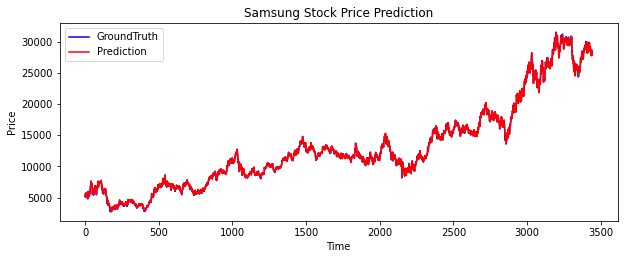

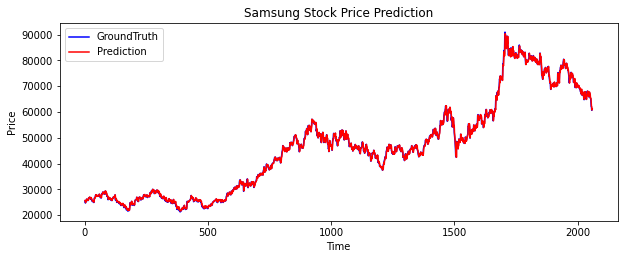

window_size : 20
unit :  75
Epoch 1/100
108/108 [==============================] - 2s 4ms/step - loss: 0.0114
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 3.7351e-04
Epoch 3/100
108/108 [==============================] - 0s 4ms/step - loss: 3.4395e-04
Epoch 4/100
108/108 [==============================] - 0s 4ms/step - loss: 3.1879e-04
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss: 3.2144e-04
Epoch 6/100
108/108 [==============================] - 0s 4ms/step - loss: 3.0018e-04
Epoch 7/100
108/108 [==============================] - 0s 4ms/step - loss: 2.8251e-04
Epoch 8/100
108/108 [==============================] - 0s 4ms/step - loss: 2.7938e-04
Epoch 9/100
108/108 [==============================] - 0s 4ms/step - loss: 2.9432e-04
Epoch 10/100
108/108 [==============================] - 0s 4ms/step - loss: 2.5258e-04
Epoch 11/100
108/108 [==============================] - 0s 4ms/step - loss: 2.5754e-04
Epoch 12/100
108/108 [======

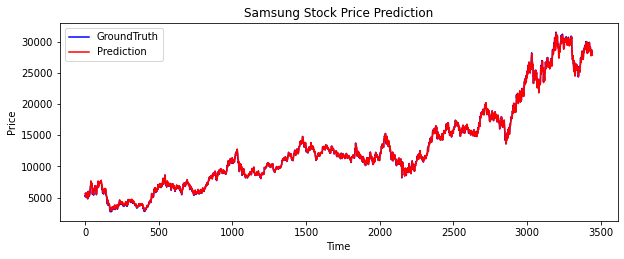

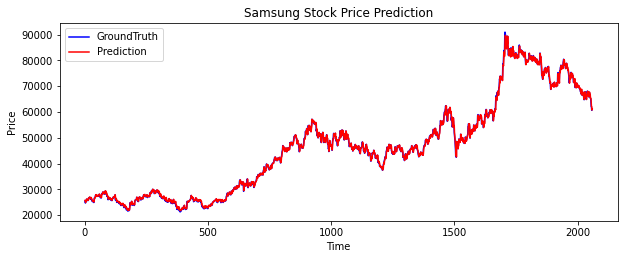

window_size : 20
unit :  50
Epoch 1/100
108/108 [==============================] - 2s 4ms/step - loss: 0.0135
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 3.6566e-04
Epoch 3/100
108/108 [==============================] - 0s 4ms/step - loss: 3.6938e-04
Epoch 4/100
108/108 [==============================] - 0s 4ms/step - loss: 3.3968e-04
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss: 3.3858e-04
Epoch 6/100
108/108 [==============================] - 0s 4ms/step - loss: 2.7269e-04
Epoch 7/100
108/108 [==============================] - 0s 4ms/step - loss: 2.6616e-04
Epoch 8/100
108/108 [==============================] - 0s 4ms/step - loss: 2.5994e-04
Epoch 9/100
108/108 [==============================] - 0s 4ms/step - loss: 3.3014e-04
Epoch 10/100
108/108 [==============================] - 0s 4ms/step - loss: 2.3132e-04
Epoch 11/100
108/108 [==============================] - 0s 4ms/step - loss: 2.5449e-04
Epoch 12/100
108/108 [======

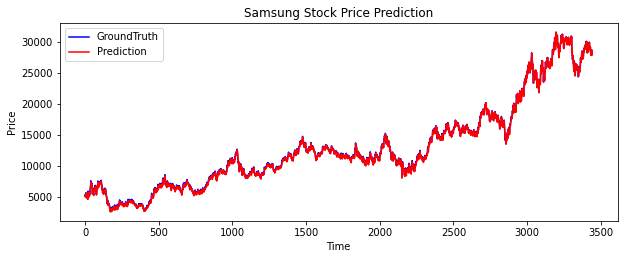

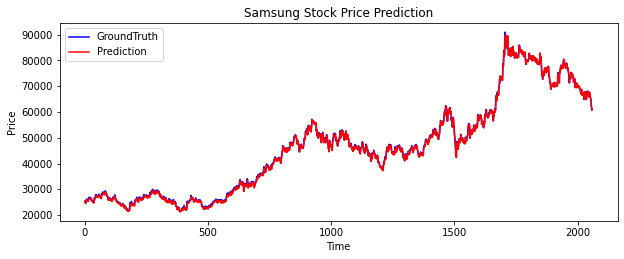

window_size : 20
unit :  25
Epoch 1/100
108/108 [==============================] - 2s 4ms/step - loss: 0.0207
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 3.8613e-04
Epoch 3/100
108/108 [==============================] - 0s 3ms/step - loss: 3.2503e-04
Epoch 4/100
108/108 [==============================] - 0s 4ms/step - loss: 2.9853e-04
Epoch 5/100
108/108 [==============================] - 0s 3ms/step - loss: 2.8438e-04
Epoch 6/100
108/108 [==============================] - 0s 3ms/step - loss: 2.8239e-04
Epoch 7/100
108/108 [==============================] - 0s 3ms/step - loss: 2.4526e-04
Epoch 8/100
108/108 [==============================] - 0s 3ms/step - loss: 2.3125e-04
Epoch 9/100
108/108 [==============================] - 0s 3ms/step - loss: 2.3136e-04
Epoch 10/100
108/108 [==============================] - 0s 4ms/step - loss: 2.0856e-04
Epoch 11/100
108/108 [==============================] - 0s 3ms/step - loss: 2.1760e-04
Epoch 12/100
108/108 [======

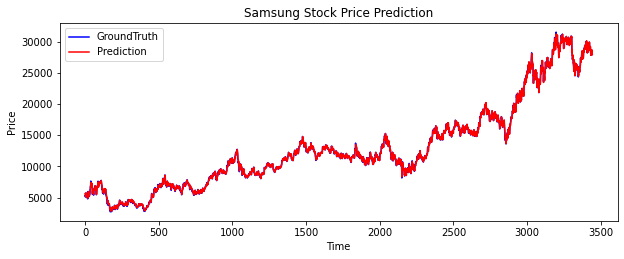

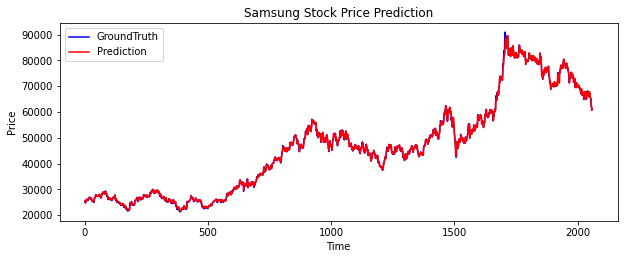

window_size : 10
unit :  100
Epoch 1/100
108/108 [==============================] - 2s 3ms/step - loss: 0.0126
Epoch 2/100
108/108 [==============================] - 0s 3ms/step - loss: 3.1777e-04
Epoch 3/100
108/108 [==============================] - 0s 3ms/step - loss: 3.0181e-04
Epoch 4/100
108/108 [==============================] - 0s 3ms/step - loss: 3.1025e-04
Epoch 5/100
108/108 [==============================] - 0s 3ms/step - loss: 3.0620e-04
Epoch 6/100
108/108 [==============================] - 0s 3ms/step - loss: 3.3402e-04
Epoch 7/100
108/108 [==============================] - 0s 3ms/step - loss: 2.9842e-04
Epoch 8/100
108/108 [==============================] - 0s 3ms/step - loss: 2.8599e-04
Epoch 9/100
108/108 [==============================] - 0s 3ms/step - loss: 2.6869e-04
Epoch 10/100
108/108 [==============================] - 0s 3ms/step - loss: 2.6843e-04
Epoch 11/100
108/108 [==============================] - 0s 3ms/step - loss: 2.7913e-04
Epoch 12/100
108/108 [=====

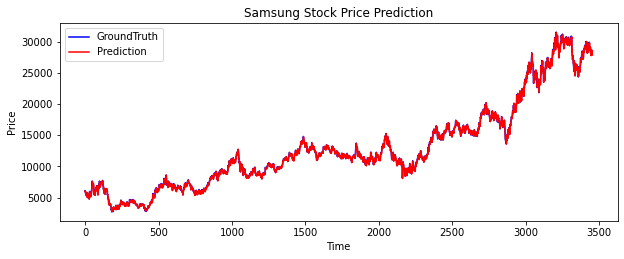

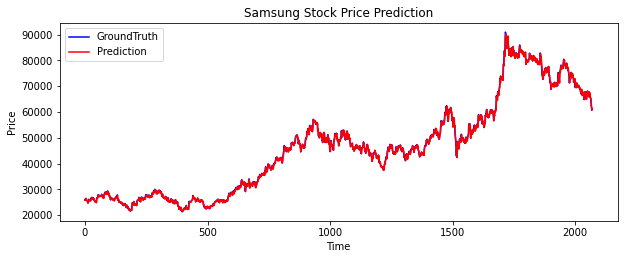

window_size : 10
unit :  75
Epoch 1/100
108/108 [==============================] - 2s 3ms/step - loss: 0.0026
Epoch 2/100
108/108 [==============================] - 0s 3ms/step - loss: 2.3614e-04
Epoch 3/100
108/108 [==============================] - 0s 3ms/step - loss: 2.4070e-04
Epoch 4/100
108/108 [==============================] - 0s 3ms/step - loss: 2.2613e-04
Epoch 5/100
108/108 [==============================] - 0s 3ms/step - loss: 2.3935e-04
Epoch 6/100
108/108 [==============================] - 0s 3ms/step - loss: 2.3680e-04
Epoch 7/100
108/108 [==============================] - 0s 3ms/step - loss: 2.1887e-04
Epoch 8/100
108/108 [==============================] - 0s 3ms/step - loss: 2.3300e-04
Epoch 9/100
108/108 [==============================] - 0s 3ms/step - loss: 2.1962e-04
Epoch 10/100
108/108 [==============================] - 0s 3ms/step - loss: 2.1175e-04
Epoch 11/100
108/108 [==============================] - 0s 3ms/step - loss: 1.9711e-04
Epoch 12/100
108/108 [======

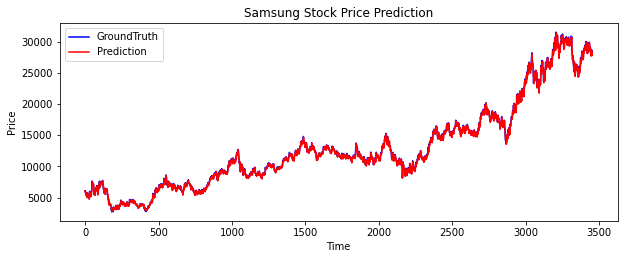

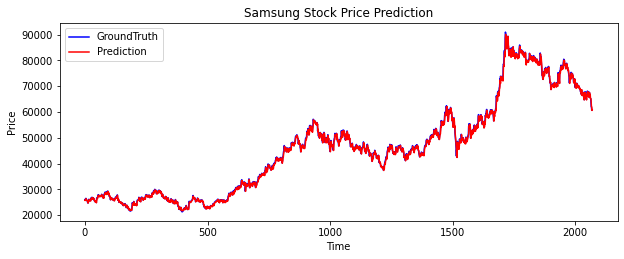

window_size : 10
unit :  50
Epoch 1/100
108/108 [==============================] - 2s 4ms/step - loss: 0.0053
Epoch 2/100
108/108 [==============================] - 0s 3ms/step - loss: 2.4121e-04
Epoch 3/100
108/108 [==============================] - 0s 3ms/step - loss: 2.4353e-04
Epoch 4/100
108/108 [==============================] - 0s 3ms/step - loss: 2.2565e-04
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss: 2.2437e-04
Epoch 6/100
108/108 [==============================] - 0s 4ms/step - loss: 2.2218e-04
Epoch 7/100
108/108 [==============================] - 0s 4ms/step - loss: 2.2573e-04
Epoch 8/100
108/108 [==============================] - 0s 3ms/step - loss: 2.0896e-04
Epoch 9/100
108/108 [==============================] - 0s 3ms/step - loss: 1.9944e-04
Epoch 10/100
108/108 [==============================] - 0s 3ms/step - loss: 2.0518e-04
Epoch 11/100
108/108 [==============================] - 0s 3ms/step - loss: 2.0816e-04
Epoch 12/100
108/108 [======

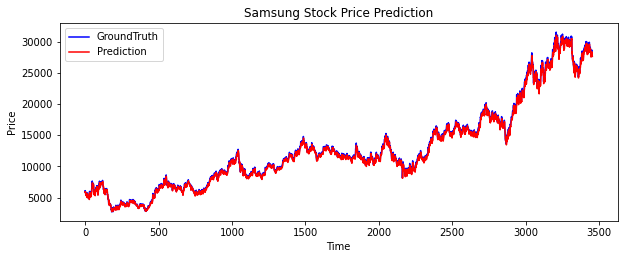

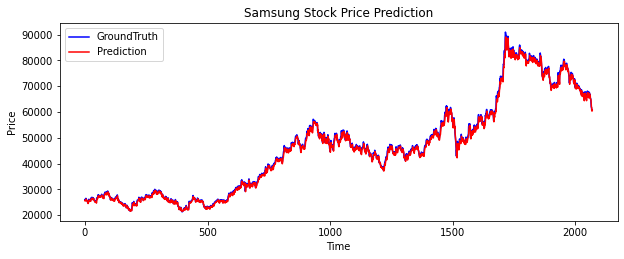

window_size : 10
unit :  25
Epoch 1/100
108/108 [==============================] - 2s 3ms/step - loss: 0.0410
Epoch 2/100
108/108 [==============================] - 0s 3ms/step - loss: 3.6746e-04
Epoch 3/100
108/108 [==============================] - 0s 3ms/step - loss: 2.9457e-04
Epoch 4/100
108/108 [==============================] - 0s 3ms/step - loss: 2.8738e-04
Epoch 5/100
108/108 [==============================] - 0s 3ms/step - loss: 2.9892e-04
Epoch 6/100
108/108 [==============================] - 0s 3ms/step - loss: 2.7987e-04
Epoch 7/100
108/108 [==============================] - 0s 3ms/step - loss: 2.8223e-04
Epoch 8/100
108/108 [==============================] - 0s 3ms/step - loss: 2.7647e-04
Epoch 9/100
108/108 [==============================] - 0s 3ms/step - loss: 2.6553e-04
Epoch 10/100
108/108 [==============================] - 0s 3ms/step - loss: 2.7729e-04
Epoch 11/100
108/108 [==============================] - 0s 3ms/step - loss: 2.6711e-04
Epoch 12/100
108/108 [======

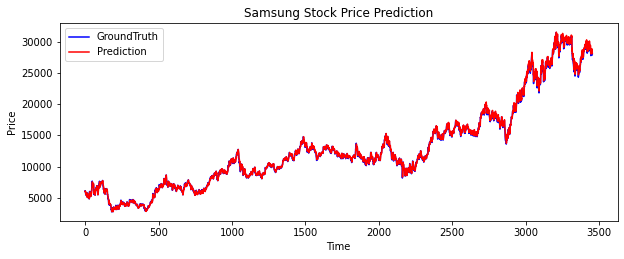

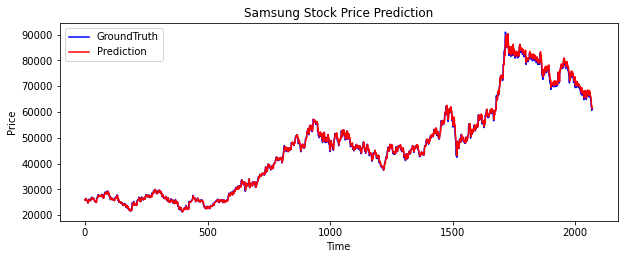

In [46]:
windows = [60, 30, 20, 10]
units = [100, 75, 50, 25]

for window in windows :
    for unit in units :
        print("window_size :" , window)
        print("unit : ", unit)
        test2(window, unit)

window_size : 60
unit :  100
Epoch 1/100
107/107 [==============================] - 3s 14ms/step - loss: 0.0068 - mse: 0.0136 - val_loss: 3.4452e-04 - val_mse: 6.8904e-04
Epoch 2/100
107/107 [==============================] - 1s 10ms/step - loss: 2.1967e-04 - mse: 4.3935e-04 - val_loss: 2.8781e-04 - val_mse: 5.7562e-04
Epoch 3/100
107/107 [==============================] - 1s 10ms/step - loss: 1.8994e-04 - mse: 3.7988e-04 - val_loss: 2.6437e-04 - val_mse: 5.2874e-04
Epoch 4/100
107/107 [==============================] - 1s 9ms/step - loss: 1.7188e-04 - mse: 3.4376e-04 - val_loss: 2.3583e-04 - val_mse: 4.7167e-04
Epoch 5/100
107/107 [==============================] - 1s 9ms/step - loss: 1.5428e-04 - mse: 3.0857e-04 - val_loss: 2.1955e-04 - val_mse: 4.3911e-04
Epoch 6/100
107/107 [==============================] - 1s 9ms/step - loss: 1.5553e-04 - mse: 3.1106e-04 - val_loss: 3.0426e-04 - val_mse: 6.0852e-04
Epoch 7/100
107/107 [==============================] - 1s 9ms/step - loss: 1.5483e

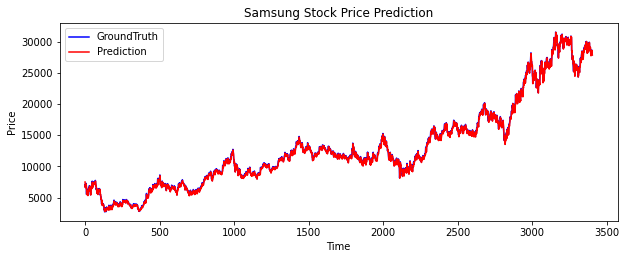

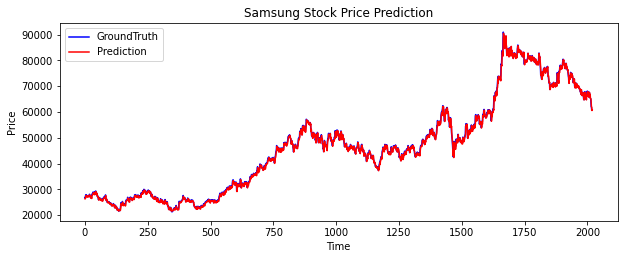

window_size : 60
unit :  75
Epoch 1/100
107/107 [==============================] - 3s 12ms/step - loss: 0.0066 - mse: 0.0131 - val_loss: 3.9084e-04 - val_mse: 7.8169e-04
Epoch 2/100
107/107 [==============================] - 1s 9ms/step - loss: 2.2032e-04 - mse: 4.4064e-04 - val_loss: 3.3240e-04 - val_mse: 6.6480e-04
Epoch 3/100
107/107 [==============================] - 1s 9ms/step - loss: 1.9176e-04 - mse: 3.8353e-04 - val_loss: 2.9318e-04 - val_mse: 5.8637e-04
Epoch 4/100
107/107 [==============================] - 1s 9ms/step - loss: 1.7696e-04 - mse: 3.5393e-04 - val_loss: 2.5200e-04 - val_mse: 5.0400e-04
Epoch 5/100
107/107 [==============================] - 1s 9ms/step - loss: 1.5285e-04 - mse: 3.0571e-04 - val_loss: 2.2682e-04 - val_mse: 4.5363e-04
Epoch 6/100
107/107 [==============================] - 1s 9ms/step - loss: 1.4011e-04 - mse: 2.8022e-04 - val_loss: 1.8563e-04 - val_mse: 3.7125e-04
Epoch 7/100
107/107 [==============================] - 1s 9ms/step - loss: 1.4170e-04

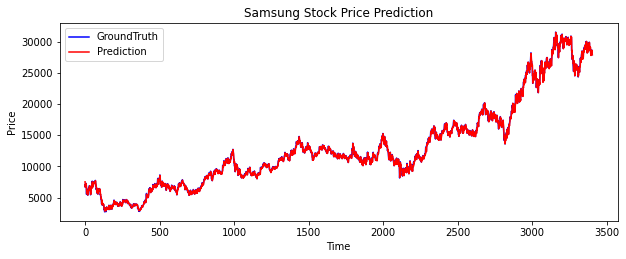

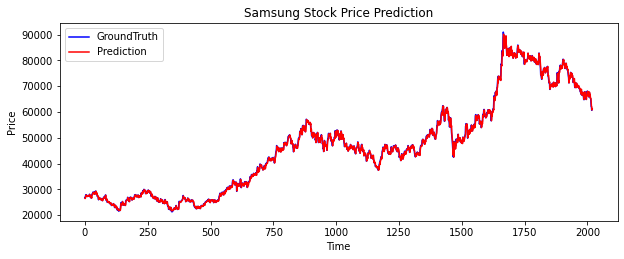

window_size : 60
unit :  50
Epoch 1/100
107/107 [==============================] - 2s 11ms/step - loss: 0.0121 - mse: 0.0241 - val_loss: 4.2433e-04 - val_mse: 8.4866e-04
Epoch 2/100
107/107 [==============================] - 1s 8ms/step - loss: 2.3636e-04 - mse: 4.7273e-04 - val_loss: 3.4629e-04 - val_mse: 6.9259e-04
Epoch 3/100
107/107 [==============================] - 1s 8ms/step - loss: 2.0693e-04 - mse: 4.1386e-04 - val_loss: 3.3062e-04 - val_mse: 6.6123e-04
Epoch 4/100
107/107 [==============================] - 1s 8ms/step - loss: 1.9739e-04 - mse: 3.9477e-04 - val_loss: 3.0515e-04 - val_mse: 6.1030e-04
Epoch 5/100
107/107 [==============================] - 1s 8ms/step - loss: 1.8266e-04 - mse: 3.6532e-04 - val_loss: 2.7169e-04 - val_mse: 5.4338e-04
Epoch 6/100
107/107 [==============================] - 1s 8ms/step - loss: 1.8363e-04 - mse: 3.6726e-04 - val_loss: 2.5513e-04 - val_mse: 5.1027e-04
Epoch 7/100
107/107 [==============================] - 1s 8ms/step - loss: 1.6368e-04

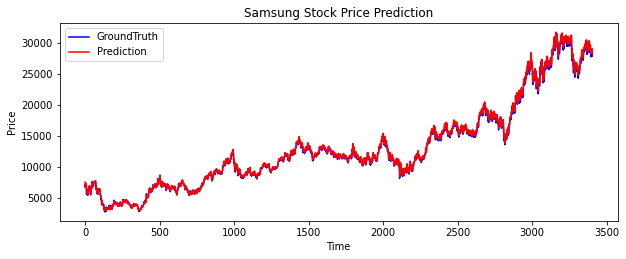

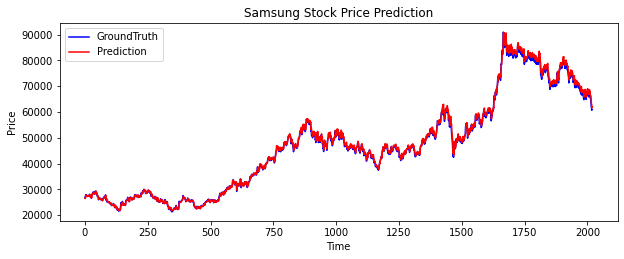

window_size : 60
unit :  25
Epoch 1/100
107/107 [==============================] - 2s 11ms/step - loss: 0.0183 - mse: 0.0365 - val_loss: 4.1411e-04 - val_mse: 8.2822e-04
Epoch 2/100
107/107 [==============================] - 1s 7ms/step - loss: 2.3265e-04 - mse: 4.6529e-04 - val_loss: 3.4677e-04 - val_mse: 6.9353e-04
Epoch 3/100
107/107 [==============================] - 1s 8ms/step - loss: 2.0038e-04 - mse: 4.0077e-04 - val_loss: 3.6569e-04 - val_mse: 7.3139e-04
Epoch 4/100
107/107 [==============================] - 1s 8ms/step - loss: 1.8869e-04 - mse: 3.7738e-04 - val_loss: 3.0901e-04 - val_mse: 6.1802e-04
Epoch 5/100
107/107 [==============================] - 1s 8ms/step - loss: 1.9196e-04 - mse: 3.8392e-04 - val_loss: 2.8453e-04 - val_mse: 5.6907e-04
Epoch 6/100
107/107 [==============================] - 1s 8ms/step - loss: 1.7348e-04 - mse: 3.4697e-04 - val_loss: 2.6465e-04 - val_mse: 5.2931e-04
Epoch 7/100
107/107 [==============================] - 1s 8ms/step - loss: 1.7134e-04

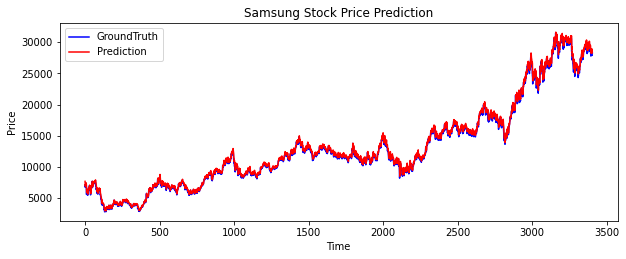

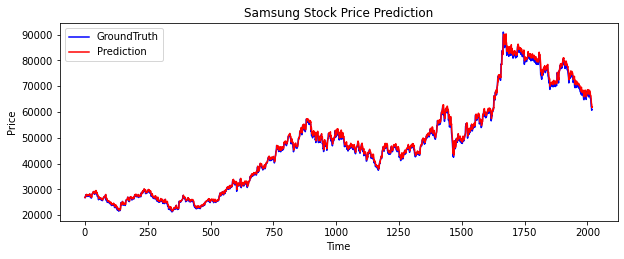

window_size : 30
unit :  100
Epoch 1/100
108/108 [==============================] - 2s 10ms/step - loss: 0.0050 - mse: 0.0101 - val_loss: 3.9047e-04 - val_mse: 7.8094e-04
Epoch 2/100
108/108 [==============================] - 1s 7ms/step - loss: 2.3752e-04 - mse: 4.7504e-04 - val_loss: 3.7823e-04 - val_mse: 7.5646e-04
Epoch 3/100
108/108 [==============================] - 1s 7ms/step - loss: 2.2547e-04 - mse: 4.5094e-04 - val_loss: 3.3369e-04 - val_mse: 6.6739e-04
Epoch 4/100
108/108 [==============================] - 1s 7ms/step - loss: 2.1559e-04 - mse: 4.3119e-04 - val_loss: 2.9761e-04 - val_mse: 5.9522e-04
Epoch 5/100
108/108 [==============================] - 1s 7ms/step - loss: 1.8370e-04 - mse: 3.6740e-04 - val_loss: 2.5458e-04 - val_mse: 5.0917e-04
Epoch 6/100
108/108 [==============================] - 1s 7ms/step - loss: 1.9481e-04 - mse: 3.8961e-04 - val_loss: 2.6568e-04 - val_mse: 5.3136e-04
Epoch 7/100
108/108 [==============================] - 1s 6ms/step - loss: 1.7407e-0

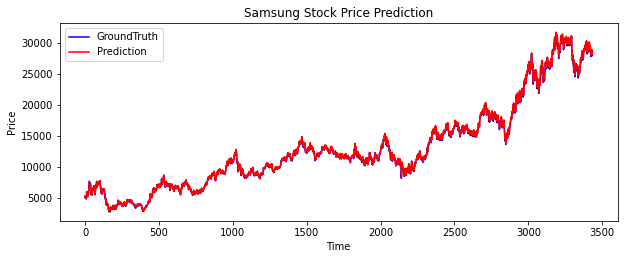

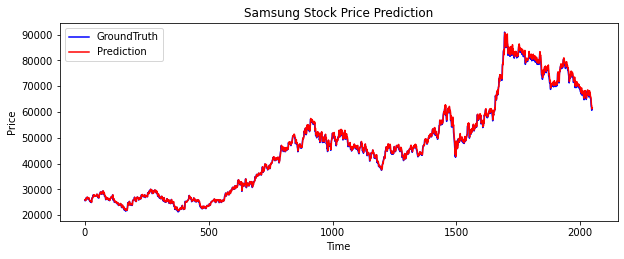

window_size : 30
unit :  75
Epoch 1/100
108/108 [==============================] - 2s 10ms/step - loss: 0.0054 - mse: 0.0109 - val_loss: 3.3904e-04 - val_mse: 6.7808e-04
Epoch 2/100
108/108 [==============================] - 1s 7ms/step - loss: 2.0408e-04 - mse: 4.0816e-04 - val_loss: 2.9922e-04 - val_mse: 5.9843e-04
Epoch 3/100
108/108 [==============================] - 1s 7ms/step - loss: 1.8605e-04 - mse: 3.7210e-04 - val_loss: 3.1936e-04 - val_mse: 6.3873e-04
Epoch 4/100
108/108 [==============================] - 1s 7ms/step - loss: 1.8049e-04 - mse: 3.6099e-04 - val_loss: 2.5876e-04 - val_mse: 5.1752e-04
Epoch 5/100
108/108 [==============================] - 1s 7ms/step - loss: 1.6474e-04 - mse: 3.2947e-04 - val_loss: 2.4639e-04 - val_mse: 4.9278e-04
Epoch 6/100
108/108 [==============================] - 1s 7ms/step - loss: 1.5974e-04 - mse: 3.1947e-04 - val_loss: 2.3643e-04 - val_mse: 4.7287e-04
Epoch 7/100
108/108 [==============================] - 1s 7ms/step - loss: 1.5304e-04

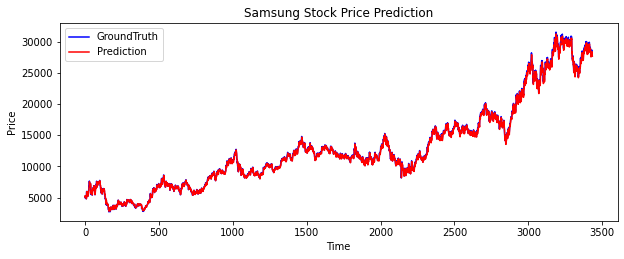

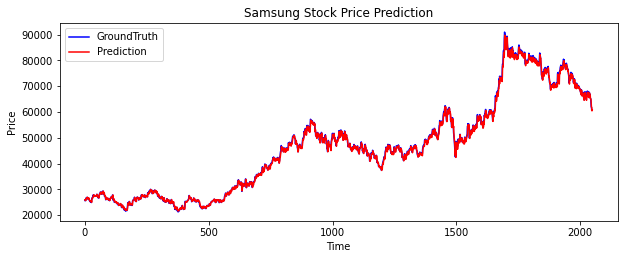

window_size : 30
unit :  50
Epoch 1/100
108/108 [==============================] - 2s 10ms/step - loss: 0.0093 - mse: 0.0186 - val_loss: 3.6389e-04 - val_mse: 7.2777e-04
Epoch 2/100
108/108 [==============================] - 1s 7ms/step - loss: 2.1849e-04 - mse: 4.3698e-04 - val_loss: 3.5872e-04 - val_mse: 7.1744e-04
Epoch 3/100
108/108 [==============================] - 1s 7ms/step - loss: 2.0339e-04 - mse: 4.0679e-04 - val_loss: 3.0749e-04 - val_mse: 6.1497e-04
Epoch 4/100
108/108 [==============================] - 1s 7ms/step - loss: 1.9549e-04 - mse: 3.9097e-04 - val_loss: 3.0862e-04 - val_mse: 6.1724e-04
Epoch 5/100
108/108 [==============================] - 1s 7ms/step - loss: 1.9530e-04 - mse: 3.9060e-04 - val_loss: 2.7573e-04 - val_mse: 5.5145e-04
Epoch 6/100
108/108 [==============================] - 1s 7ms/step - loss: 1.8275e-04 - mse: 3.6550e-04 - val_loss: 2.6544e-04 - val_mse: 5.3088e-04
Epoch 7/100
108/108 [==============================] - 1s 6ms/step - loss: 1.8135e-04

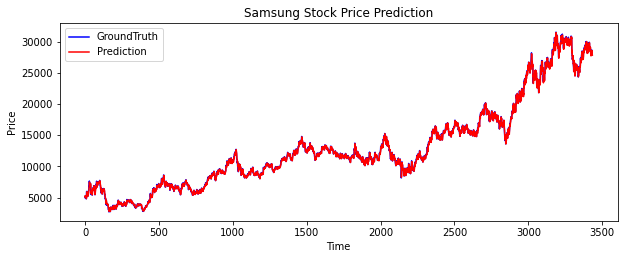

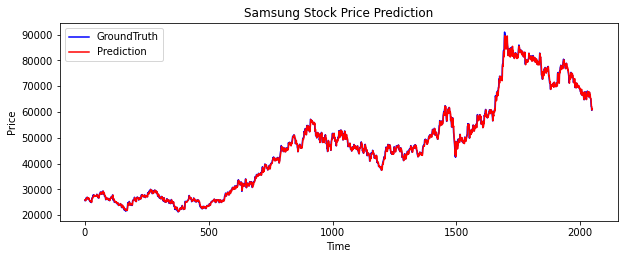

window_size : 30
unit :  25
Epoch 1/100
108/108 [==============================] - 2s 9ms/step - loss: 0.0215 - mse: 0.0431 - val_loss: 3.9636e-04 - val_mse: 7.9272e-04
Epoch 2/100
108/108 [==============================] - 1s 6ms/step - loss: 2.2826e-04 - mse: 4.5653e-04 - val_loss: 3.6910e-04 - val_mse: 7.3820e-04
Epoch 3/100
108/108 [==============================] - 1s 6ms/step - loss: 2.1195e-04 - mse: 4.2390e-04 - val_loss: 3.2917e-04 - val_mse: 6.5834e-04
Epoch 4/100
108/108 [==============================] - 1s 6ms/step - loss: 2.0503e-04 - mse: 4.1007e-04 - val_loss: 4.1054e-04 - val_mse: 8.2108e-04
Epoch 5/100
108/108 [==============================] - 1s 6ms/step - loss: 2.0456e-04 - mse: 4.0911e-04 - val_loss: 3.4521e-04 - val_mse: 6.9042e-04
Epoch 6/100
108/108 [==============================] - 1s 6ms/step - loss: 2.0407e-04 - mse: 4.0813e-04 - val_loss: 3.1143e-04 - val_mse: 6.2286e-04
Epoch 7/100
108/108 [==============================] - 1s 6ms/step - loss: 1.9957e-04 

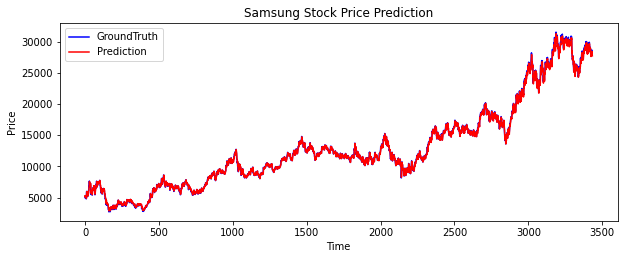

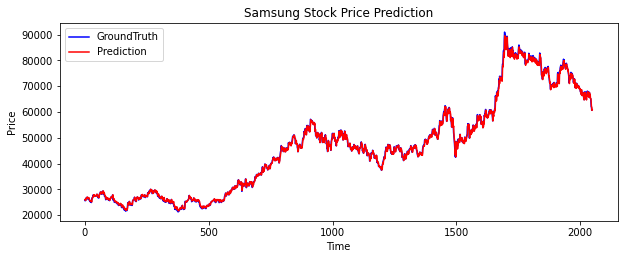

window_size : 20
unit :  100
Epoch 1/100
108/108 [==============================] - 2s 10ms/step - loss: 0.0044 - mse: 0.0088 - val_loss: 3.4610e-04 - val_mse: 6.9220e-04
Epoch 2/100
108/108 [==============================] - 1s 7ms/step - loss: 2.1285e-04 - mse: 4.2571e-04 - val_loss: 3.0826e-04 - val_mse: 6.1651e-04
Epoch 3/100
108/108 [==============================] - 1s 7ms/step - loss: 2.0096e-04 - mse: 4.0193e-04 - val_loss: 2.8545e-04 - val_mse: 5.7090e-04
Epoch 4/100
108/108 [==============================] - 1s 7ms/step - loss: 1.8122e-04 - mse: 3.6244e-04 - val_loss: 2.7925e-04 - val_mse: 5.5850e-04
Epoch 5/100
108/108 [==============================] - 1s 7ms/step - loss: 1.7326e-04 - mse: 3.4653e-04 - val_loss: 2.5445e-04 - val_mse: 5.0890e-04
Epoch 6/100
108/108 [==============================] - 1s 6ms/step - loss: 1.6593e-04 - mse: 3.3186e-04 - val_loss: 2.5446e-04 - val_mse: 5.0892e-04
Epoch 7/100
108/108 [==============================] - 1s 6ms/step - loss: 1.5544e-0

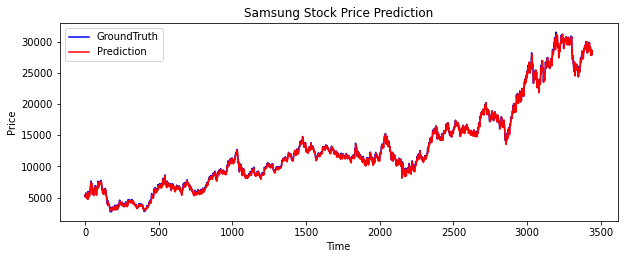

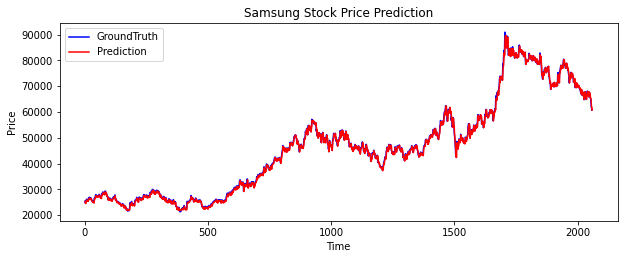

window_size : 20
unit :  75
Epoch 1/100
108/108 [==============================] - 2s 10ms/step - loss: 0.0248 - mse: 0.0496 - val_loss: 6.9128e-04 - val_mse: 0.0014
Epoch 2/100
108/108 [==============================] - 1s 6ms/step - loss: 3.9158e-04 - mse: 7.8315e-04 - val_loss: 6.0392e-04 - val_mse: 0.0012
Epoch 3/100
108/108 [==============================] - 1s 8ms/step - loss: 3.5312e-04 - mse: 7.0624e-04 - val_loss: 5.3437e-04 - val_mse: 0.0011
Epoch 4/100
108/108 [==============================] - 1s 7ms/step - loss: 3.0919e-04 - mse: 6.1838e-04 - val_loss: 4.8140e-04 - val_mse: 9.6281e-04
Epoch 5/100
108/108 [==============================] - 1s 7ms/step - loss: 2.9604e-04 - mse: 5.9208e-04 - val_loss: 4.7143e-04 - val_mse: 9.4286e-04
Epoch 6/100
108/108 [==============================] - 1s 7ms/step - loss: 2.7112e-04 - mse: 5.4223e-04 - val_loss: 4.5516e-04 - val_mse: 9.1033e-04
Epoch 7/100
108/108 [==============================] - 1s 7ms/step - loss: 2.8561e-04 - mse: 5.71

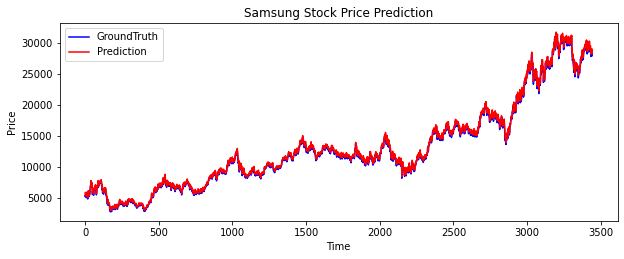

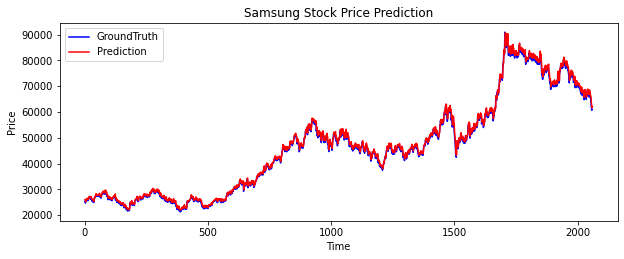

window_size : 20
unit :  50
Epoch 1/100
108/108 [==============================] - 3s 9ms/step - loss: 0.0172 - mse: 0.0345 - val_loss: 4.0890e-04 - val_mse: 8.1781e-04
Epoch 2/100
108/108 [==============================] - 1s 6ms/step - loss: 2.3302e-04 - mse: 4.6604e-04 - val_loss: 3.7918e-04 - val_mse: 7.5837e-04
Epoch 3/100
108/108 [==============================] - 1s 6ms/step - loss: 2.0532e-04 - mse: 4.1064e-04 - val_loss: 3.2291e-04 - val_mse: 6.4581e-04
Epoch 4/100
108/108 [==============================] - 1s 6ms/step - loss: 1.9586e-04 - mse: 3.9173e-04 - val_loss: 3.2168e-04 - val_mse: 6.4337e-04
Epoch 5/100
108/108 [==============================] - 1s 6ms/step - loss: 1.8223e-04 - mse: 3.6445e-04 - val_loss: 3.3702e-04 - val_mse: 6.7403e-04
Epoch 6/100
108/108 [==============================] - 1s 5ms/step - loss: 1.7523e-04 - mse: 3.5046e-04 - val_loss: 2.5724e-04 - val_mse: 5.1448e-04
Epoch 7/100
108/108 [==============================] - 1s 5ms/step - loss: 1.8193e-04 

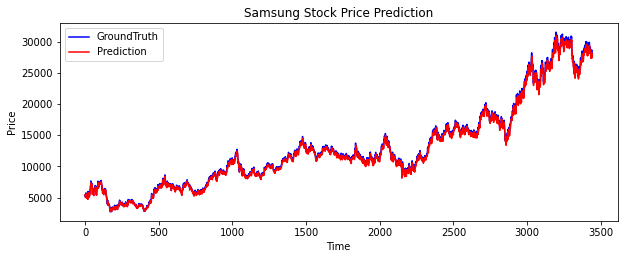

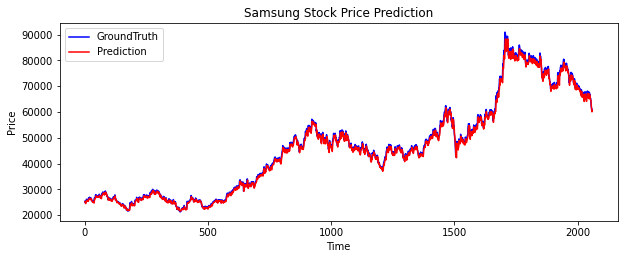

window_size : 20
unit :  25
Epoch 1/100
108/108 [==============================] - 2s 10ms/step - loss: 0.0074 - mse: 0.0148 - val_loss: 3.2168e-04 - val_mse: 6.4335e-04
Epoch 2/100
108/108 [==============================] - 1s 6ms/step - loss: 1.9145e-04 - mse: 3.8289e-04 - val_loss: 2.9080e-04 - val_mse: 5.8160e-04
Epoch 3/100
108/108 [==============================] - 1s 6ms/step - loss: 1.8551e-04 - mse: 3.7102e-04 - val_loss: 2.8834e-04 - val_mse: 5.7668e-04
Epoch 4/100
108/108 [==============================] - 1s 6ms/step - loss: 1.7960e-04 - mse: 3.5921e-04 - val_loss: 2.7919e-04 - val_mse: 5.5837e-04
Epoch 5/100
108/108 [==============================] - 1s 6ms/step - loss: 1.7441e-04 - mse: 3.4881e-04 - val_loss: 2.6182e-04 - val_mse: 5.2364e-04
Epoch 6/100
108/108 [==============================] - 1s 6ms/step - loss: 1.6938e-04 - mse: 3.3875e-04 - val_loss: 2.4962e-04 - val_mse: 4.9925e-04
Epoch 7/100
108/108 [==============================] - 1s 6ms/step - loss: 1.6557e-04

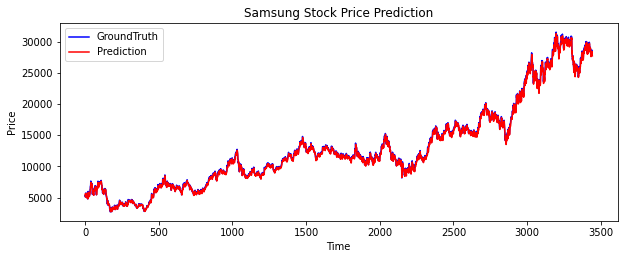

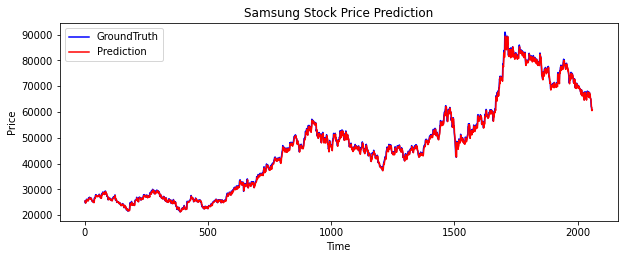

window_size : 10
unit :  100
Epoch 1/100
108/108 [==============================] - 2s 9ms/step - loss: 0.0060 - mse: 0.0120 - val_loss: 3.0930e-04 - val_mse: 6.1860e-04
Epoch 2/100
108/108 [==============================] - 1s 5ms/step - loss: 1.8884e-04 - mse: 3.7768e-04 - val_loss: 2.6287e-04 - val_mse: 5.2575e-04
Epoch 3/100
108/108 [==============================] - 1s 5ms/step - loss: 1.7837e-04 - mse: 3.5674e-04 - val_loss: 2.5841e-04 - val_mse: 5.1682e-04
Epoch 4/100
108/108 [==============================] - 1s 5ms/step - loss: 1.7818e-04 - mse: 3.5636e-04 - val_loss: 2.8686e-04 - val_mse: 5.7371e-04
Epoch 5/100
108/108 [==============================] - 1s 5ms/step - loss: 1.7721e-04 - mse: 3.5442e-04 - val_loss: 2.4413e-04 - val_mse: 4.8827e-04
Epoch 6/100
108/108 [==============================] - 1s 5ms/step - loss: 1.6741e-04 - mse: 3.3482e-04 - val_loss: 2.4973e-04 - val_mse: 4.9945e-04
Epoch 7/100
108/108 [==============================] - 1s 5ms/step - loss: 1.6916e-04

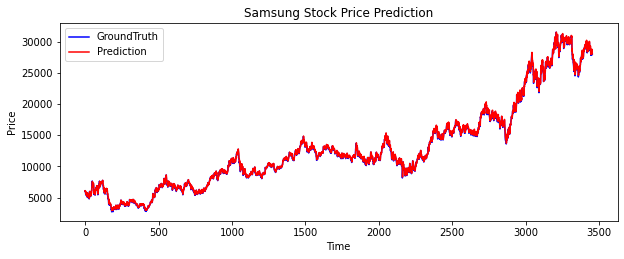

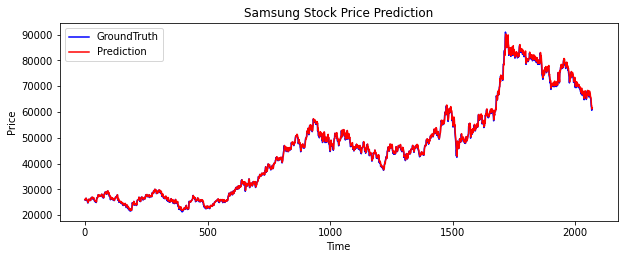

window_size : 10
unit :  75
Epoch 1/100
108/108 [==============================] - 2s 8ms/step - loss: 0.0173 - mse: 0.0345 - val_loss: 4.4503e-04 - val_mse: 8.9006e-04
Epoch 2/100
108/108 [==============================] - 1s 6ms/step - loss: 2.2170e-04 - mse: 4.4339e-04 - val_loss: 2.9873e-04 - val_mse: 5.9747e-04
Epoch 3/100
108/108 [==============================] - 1s 6ms/step - loss: 1.9030e-04 - mse: 3.8060e-04 - val_loss: 2.8564e-04 - val_mse: 5.7128e-04
Epoch 4/100
108/108 [==============================] - 1s 5ms/step - loss: 1.8681e-04 - mse: 3.7361e-04 - val_loss: 2.8261e-04 - val_mse: 5.6522e-04
Epoch 5/100
108/108 [==============================] - 1s 5ms/step - loss: 1.8362e-04 - mse: 3.6724e-04 - val_loss: 2.7303e-04 - val_mse: 5.4607e-04
Epoch 6/100
108/108 [==============================] - 1s 5ms/step - loss: 1.9359e-04 - mse: 3.8719e-04 - val_loss: 2.8053e-04 - val_mse: 5.6106e-04
Epoch 7/100
108/108 [==============================] - 1s 5ms/step - loss: 1.8310e-04 

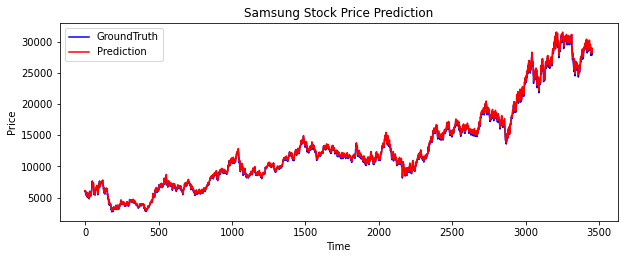

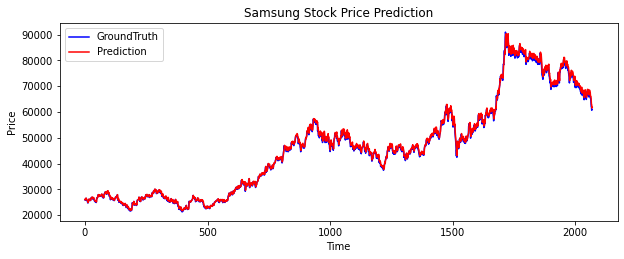

window_size : 10
unit :  50
Epoch 1/100
108/108 [==============================] - 2s 8ms/step - loss: 0.0097 - mse: 0.0193 - val_loss: 2.5613e-04 - val_mse: 5.1227e-04
Epoch 2/100
108/108 [==============================] - 1s 5ms/step - loss: 1.6739e-04 - mse: 3.3478e-04 - val_loss: 2.3983e-04 - val_mse: 4.7967e-04
Epoch 3/100
108/108 [==============================] - 1s 5ms/step - loss: 1.6078e-04 - mse: 3.2155e-04 - val_loss: 2.2910e-04 - val_mse: 4.5820e-04
Epoch 4/100
108/108 [==============================] - 1s 5ms/step - loss: 1.5577e-04 - mse: 3.1155e-04 - val_loss: 2.2370e-04 - val_mse: 4.4740e-04
Epoch 5/100
108/108 [==============================] - 1s 5ms/step - loss: 1.5114e-04 - mse: 3.0227e-04 - val_loss: 2.2250e-04 - val_mse: 4.4501e-04
Epoch 6/100
108/108 [==============================] - 1s 5ms/step - loss: 1.4684e-04 - mse: 2.9368e-04 - val_loss: 2.1771e-04 - val_mse: 4.3543e-04
Epoch 7/100
108/108 [==============================] - 1s 5ms/step - loss: 1.3955e-04 

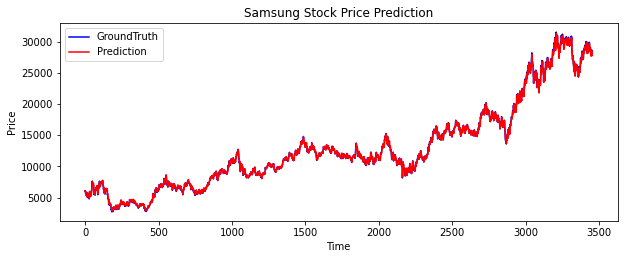

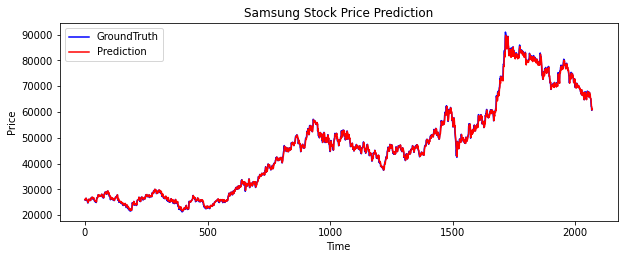

window_size : 10
unit :  25
Epoch 1/100
108/108 [==============================] - 2s 8ms/step - loss: 0.0132 - mse: 0.0264 - val_loss: 2.7854e-04 - val_mse: 5.5708e-04
Epoch 2/100
108/108 [==============================] - 1s 5ms/step - loss: 1.8007e-04 - mse: 3.6013e-04 - val_loss: 2.6982e-04 - val_mse: 5.3964e-04
Epoch 3/100
108/108 [==============================] - 1s 5ms/step - loss: 1.7680e-04 - mse: 3.5359e-04 - val_loss: 2.6964e-04 - val_mse: 5.3928e-04
Epoch 4/100
108/108 [==============================] - 1s 5ms/step - loss: 1.7373e-04 - mse: 3.4745e-04 - val_loss: 2.6634e-04 - val_mse: 5.3267e-04
Epoch 5/100
108/108 [==============================] - 1s 5ms/step - loss: 1.7473e-04 - mse: 3.4945e-04 - val_loss: 2.7023e-04 - val_mse: 5.4046e-04
Epoch 6/100
108/108 [==============================] - 1s 5ms/step - loss: 1.7650e-04 - mse: 3.5301e-04 - val_loss: 2.5923e-04 - val_mse: 5.1845e-04
Epoch 7/100
108/108 [==============================] - 1s 5ms/step - loss: 1.7398e-04 

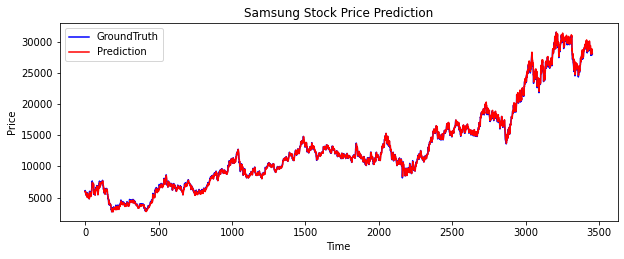

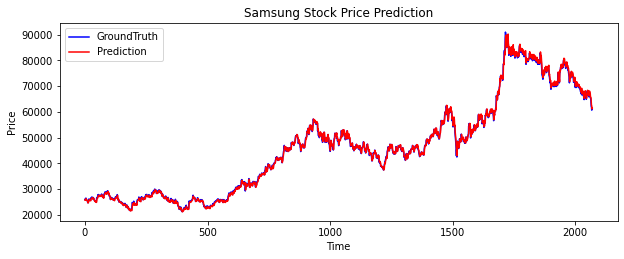

In [47]:
for window in windows :
    for unit in units :
        print("window_size :" , window)
        print("unit : ", unit)
        test(window, unit)
        test2(window, unit)

In [ ]:
test(60,75)